***
# <span style='color:Blue'>Classifier to predict yield in a semiconductor manufacturing company</span>
***

#### <span style='color:Blue'>Import the required packages</span>

In [1]:
import pandas as pd              # Perform operations on data frames
import numpy as np               # Perform numeric operations on data
import matplotlib.pyplot as plt  # For static visualizations
import seaborn as sns            # For advanced visualizations
import math
import scipy.stats as stats      # To perform statistical operations
from scipy.stats import zscore
from numpy import array
import warnings
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

#Loading all the necessary machine learning related modules
from sklearn.model_selection  import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn import metrics
from sklearn.metrics import recall_score
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import average_precision_score, confusion_matrix, accuracy_score, classification_report
import pickle

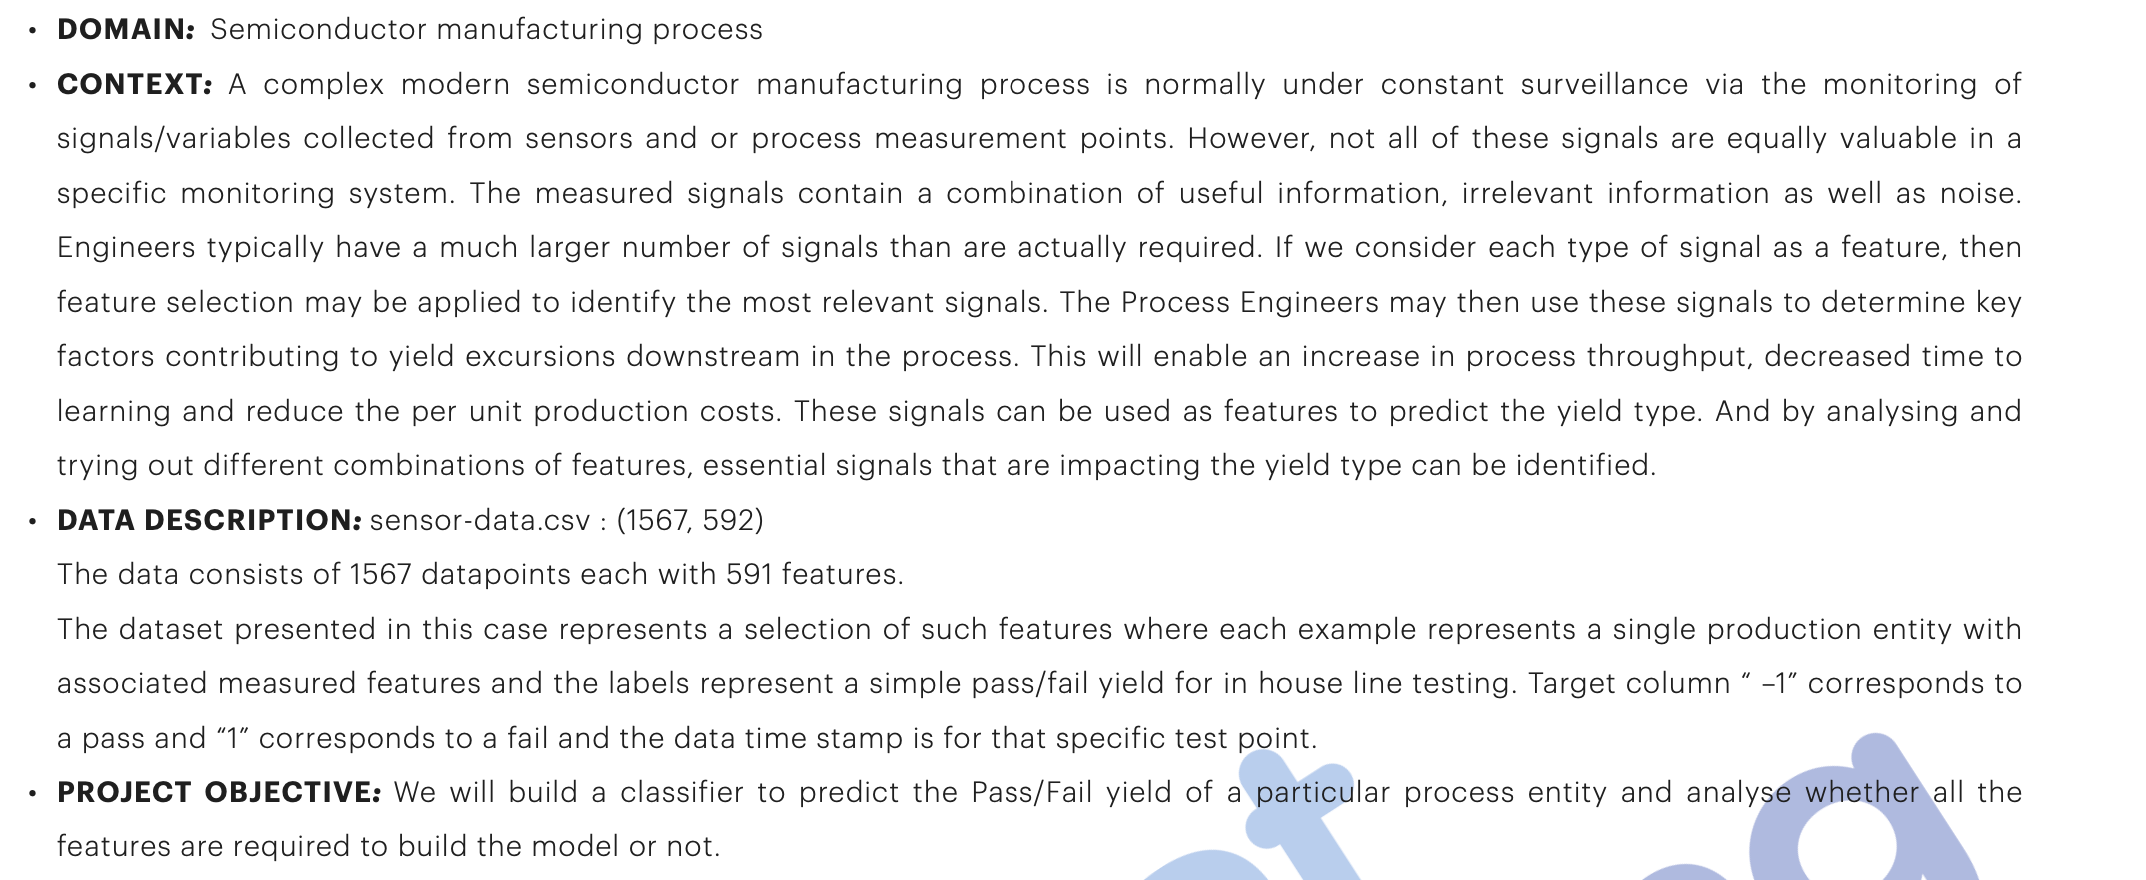

## Import and understand the data

#### Import ‘signal-data.csv’ as DataFrame

In [2]:
# Read the dataset
signal = pd.read_csv("signal-data.csv")

In [3]:
signal.head()

,Time,0,1,2,3,4,5,6,7,8,...,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1


In [4]:
signal.shape

(1567, 592)

In [5]:
# All the feature columns except Time and Pass/Fail are of float type. 
# Time is of object type.
# Pass/Fail is an integer type variable
signal.dtypes

Time          object
0            float64
1            float64
2            float64
3            float64
              ...   
586          float64
587          float64
588          float64
589          float64
Pass/Fail      int64
Length: 592, dtype: object

#### Print 5 point summary and share observations

In [6]:
signal.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
0,1561.0,3014.452896,73.621787,2743.2400,2966.260000,3011.4900,3056.6500,3356.3500
1,1560.0,2495.850231,80.407705,2158.7500,2452.247500,2499.4050,2538.8225,2846.4400
2,1553.0,2200.547318,29.513152,2060.6600,2181.044400,2201.0667,2218.0555,2315.2667
3,1553.0,1396.376627,441.691640,0.0000,1081.875800,1285.2144,1591.2235,3715.0417
4,1553.0,4.197013,56.355540,0.6815,1.017700,1.3168,1.5257,1114.5366
...,...,...,...,...,...,...,...,...
586,1566.0,0.021458,0.012358,-0.0169,0.013425,0.0205,0.0276,0.1028
587,1566.0,0.016475,0.008808,0.0032,0.010600,0.0148,0.0203,0.0799
588,1566.0,0.005283,0.002867,0.0010,0.003300,0.0046,0.0064,0.0286
589,1566.0,99.670066,93.891919,0.0000,44.368600,71.9005,114.7497,737.3048


#### <span style='color:Blue'>Observations</span>

- From the count column, we could see that some of the features have less than 1567 records, which means there are missing values in these features that needs to be imputed or dropped.
- From the std column, it can be seen that some of features have values close to zero. It means that few of the features may have very low variance and can be dropped from the analysis.
- From the min and max values, it can be observed that there is a lot of variation in range of values across features. This necessitates the scaling of data before applying machine learning techniques.


## Data cleansing

### Create loop which will remove all the features with 20%+ Null values and impute rest with mean of the feature

In [7]:
# Count of null values across all features
signal.isnull().sum()

Time          0
0             6
1             7
2            14
3            14
             ..
586           1
587           1
588           1
589           1
Pass/Fail     0
Length: 592, dtype: int64

### Remove features with >20% Null values

In [8]:
#Function to count the number of  null values in each column and find the percentage
def null_values(val):
    nullcount = int(val.isna().sum())
    length = len(val)
    pcntNull = (nullcount/length)*100
    return pcntNull

In [9]:
colsToDrop = []
print("Feature ==>", "Null values%")
for i in signal.columns:
    if( i != 'Time' and i != 'Pass/Fail'):
        nullPcnt = null_values(signal[str(i)])
        if nullPcnt > 20:
            colsToDrop.append(str(i))
            print(str(i),"==>", round(nullPcnt,2),"%")

Feature ==> Null values%
72 ==> 50.67 %
73 ==> 50.67 %
85 ==> 85.58 %
109 ==> 64.96 %
110 ==> 64.96 %
111 ==> 64.96 %
112 ==> 45.63 %
157 ==> 91.19 %
158 ==> 91.19 %
220 ==> 85.58 %
244 ==> 64.96 %
245 ==> 64.96 %
246 ==> 64.96 %
247 ==> 45.63 %
292 ==> 91.19 %
293 ==> 91.19 %
345 ==> 50.67 %
346 ==> 50.67 %
358 ==> 85.58 %
382 ==> 64.96 %
383 ==> 64.96 %
384 ==> 64.96 %
385 ==> 45.63 %
492 ==> 85.58 %
516 ==> 64.96 %
517 ==> 64.96 %
518 ==> 64.96 %
519 ==> 45.63 %
578 ==> 60.56 %
579 ==> 60.56 %
580 ==> 60.56 %
581 ==> 60.56 %


In [10]:
#print the columns to be dropped
signal[colsToDrop]

,72,73,85,109,110,111,112,157,158,220,...,385,492,516,517,518,519,578,579,580,581
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0096,0.0201,0.0060,208.2045
2,140.6972,485.2665,NaN,NaN,NaN,NaN,0.4684,NaN,NaN,NaN,...,0.0221,NaN,NaN,NaN,NaN,36.9067,0.0584,0.0484,0.0148,82.8602
3,160.3210,464.9735,NaN,NaN,NaN,NaN,0.4647,NaN,NaN,NaN,...,0.0038,NaN,NaN,NaN,NaN,4.1200,0.0202,0.0149,0.0044,73.8432
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,NaN,NaN,NaN,0.9833,102.0542,231.1404,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0832,2.7551,2.0638,NaN,0.0068,0.0138,0.0047,203.1720
1563,158.7832,463.3486,NaN,0.9824,97.5426,235.2582,NaN,NaN,NaN,NaN,...,NaN,NaN,0.1894,2.4819,1.5675,NaN,NaN,NaN,NaN,NaN
1564,NaN,NaN,0.1119,0.9839,101.4167,231.2249,NaN,NaN,NaN,0.0089,...,NaN,7.9239,0.0743,1.8912,1.9592,NaN,0.0197,0.0086,0.0025,43.5231
1565,NaN,NaN,NaN,0.9828,101.3445,233.0335,NaN,NaN,NaN,NaN,...,NaN,NaN,0.1144,2.2788,1.9770,NaN,0.0262,0.0245,0.0075,93.4941


In [11]:
# Drop columns from the dataframe without modifying the original dataframe
signalFiltered = signal.drop(columns=colsToDrop)

In [12]:
# Shape of the dataframe after dropping
signalFiltered.shape

(1567, 560)

### Impute Null values in rest of the features with their mean

In [13]:
# Check null values before imputation
nullValudDfNonFiltered = signal.isna().sum().to_frame().rename(columns={'0':'#Null_values'})

In [14]:
nullValudDfNonFiltered[0].sum()

41951

In [15]:
for i in signalFiltered.columns:
    if( i != 'Time' and i != 'Pass/Fail'):
        mean_val = signalFiltered[i].mean()
        signalFiltered[i].fillna(value=mean_val, inplace=True)

In [16]:
nullValudDfFiltered = signalFiltered.isna().sum().to_frame().rename(columns={'0':'#Null_values'})

In [17]:
# Check null values after imputation
nullValudDfFiltered[0].sum()

0

### Identify and drop the features which are having same value for all the rows

In [18]:
# Collect all the numeric features

col = []
for i in signalFiltered.columns:
    if( i != 'Time' and i != 'Pass/Fail'):
        col.append(i)
        

In [19]:
# Pairwise comparison of features to find those having same values across all rows
colDict = set()
valDict = []
for i in range(len(col)):
    for j in range(i+1,len(col)):
        col1 = col[i]
        col2 = col[j]
        #print(col1, col2)
        list1 = list(signalFiltered[col1])
        list2 = list(signalFiltered[col2])
        if list1 == list2: # Check if all values are same between features
            colDict.add(col1) # Append columns 
            colDict.add(col2)
            #valDict = valDict + list1 + list2
            valDict.append(set(list1)) # Append unique values
            valDict.append(set(list2)) # Append unique values

In [20]:
# Total columns/features before comparison
len(signalFiltered.columns)

560

In [21]:
# Features with same values across rows
len(colDict)

114

In [22]:
# Take a look at the repeating values
pd.Series(valDict).sample(20, random_state=204)

9307     {0.0}
6343     {0.0}
9135     {0.0}
8576     {0.0}
779      {0.0}
8992     {0.0}
3533     {0.0}
12231    {0.0}
3224     {0.0}
223      {1.0}
2711     {0.0}
2067     {0.0}
10062    {0.0}
2231     {0.0}
10744    {0.0}
1700     {0.0}
5805     {0.0}
7460     {0.0}
12029    {0.0}
11524    {0.0}
dtype: object

#### <span style='color:Blue'>Observations</span>
- Looks like these columns have only 0's or 1's repeated 

Let's see the distribution of columns with only 0's or 1's

In [23]:
zeroSet = {0}
oneSet = {1}
set_0 = 0
set_1 = 0
for i in valDict:
    if i == zeroSet:
        set_0 += 1  
    if i == oneSet:
        set_1 += 1
    if i != zeroSet and i != oneSet:
        print(i)
 

In [24]:
# Count of values in feature pairs with 0's and 1's
set_0, set_1

(12432, 2)

In [25]:
# Drop the columns with same values across all rows 
signalFilteredDropped = signalFiltered.drop(columns=colDict)

In [26]:
# Number of features after dropping such features
signalFilteredDropped.shape

(1567, 446)

### Drop other features if required using relevant functional knowledge

#### <span style='color:Blue'>Comment</span>
- The column time can be split into different features such as year, month, date, day etc.

In [27]:
#Create additional features with the time column
signalFilteredDropped['year'] = pd.DatetimeIndex(signalFilteredDropped['Time']).year
signalFilteredDropped['month'] = pd.DatetimeIndex(signalFilteredDropped['Time']).month
signalFilteredDropped['date'] = pd.DatetimeIndex(signalFilteredDropped['Time']).day
signalFilteredDropped['week_day'] = pd.DatetimeIndex(signalFilteredDropped['Time']).weekday
signalFilteredDropped['hour'] = pd.DatetimeIndex(signalFilteredDropped['Time']).hour
signalFilteredDropped['min'] = pd.DatetimeIndex(signalFilteredDropped['Time']).minute

In [28]:
# Drop the Time column since it has been split into respective component features
signalFilteredDropped.drop(labels='Time', axis=1,inplace=True)

In [29]:
signalFilteredDropped.shape

(1567, 451)

In [30]:
timeCols = ['year', 'month', 'date', 'week_day', 'hour', 'min']
signalFilteredDropped[timeCols].head()

,year,month,date,week_day,hour,min
0,2008,7,19,5,11,55
1,2008,7,19,5,12,32
2,2008,7,19,5,13,17
3,2008,7,19,5,14,43
4,2008,7,19,5,15,22


In [31]:
signalFilteredDropped[timeCols].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
year,1567.0,2008.000000,0.000000,2008.0,2008.0,2008.0,2008.0,2008.0
month,1567.0,7.409700,2.554511,1.0,7.0,8.0,9.0,12.0
date,1567.0,17.248883,7.613716,8.0,10.0,17.0,23.0,31.0
week_day,1567.0,3.171666,1.988605,0.0,1.0,3.0,5.0,6.0
hour,1567.0,11.780472,6.880780,0.0,6.0,12.0,18.0,23.0
min,1567.0,29.470325,17.230137,0.0,15.0,29.0,45.0,59.0


#### <span style='color:Blue'>Comment</span>

Let's check the variance for all the columns to check if any columns have all or most of the repeatitive values. If the variance of column is zero, it means all the values in column are identical.

In [32]:
variances = []
for i in signalFilteredDropped.columns:
    variances.append(signalFilteredDropped[i].var())

In [33]:
# Statistical summary of variances of all the features
pd.Series(variances).describe().to_frame().transpose()

,count,mean,std,min,25%,50%,75%,max
0,451.0,199836.933823,2.282031e+06,0.0,0.002405,1.359169,88.291942,4.289442e+07


In [34]:
# Find features with zero variance
for i in range(len(variances)):
    if (variances[i]==0):
        print(variances[i], signalFilteredDropped.columns[i])

0.0 5
0.0 42
0.0 year


In [35]:
#Drop the columns that has 0 variances
signalFilteredDropped.drop(labels=['5','42','year'], axis=1, inplace=True)
signalFilteredDropped.shape

(1567, 448)

### Check for multi-collinearity in the data and take necessary action

In [36]:
# Calculate the pairwise correlation coefficients of all the features
cor= signalFilteredDropped.corr()
cor.loc[:,:] = np.tril(cor,k=-1)
cor=cor.stack()

# Save features with correlation coefficients > 0.75 or < -0.75
highCor = cor[(cor >= 0.75) | (cor <= -0.75)]

In [37]:
highCor

17   11     0.793896
26   25     0.823111
27   25     0.980375
     26     0.790933
30   29     0.858147
              ...   
577  576    0.859278
584  583    0.994771
585  583    0.999890
     584    0.995342
588  587    0.974276
Length: 661, dtype: float64

In [38]:
len(highCor)

661

In [39]:
colPairs = list(highCor.index)

In [40]:
colPairsDf = pd.DataFrame(colPairs).rename(columns={0:'Feature1', 1:'Feature2'})

In [41]:
colPairsDf

,Feature1,Feature2
0,17,11
1,26,25
2,27,25
3,27,26
4,30,29
...,...,...
656,577,576
657,584,583
658,585,583
659,585,584


In [42]:
# Drop one of these highly correlated features to remove colinearity in the data
signalFilteredDropped2 = signalFilteredDropped.drop(columns=list(colPairsDf['Feature2']))

In [43]:
# Confirm if the highly correlated features are dropped from the data
cor2= signalFilteredDropped2.corr()
cor2.loc[:,:] = np.tril(cor2,k=-1)
cor2=cor2.stack()
highCor2 = cor2[(cor2 >= 0.75) | (cor2 <= -0.75)]
len(highCor2)

0

### Make all relevant modifications on the data using both functional/logical reasoning/assumptions

### Outlier detection for each of the features
- Those with >=20% outliers will be dropped
- Those with outliers >5% and <20% will be imputed using median values of respective features

In [44]:
# Function to calculate upper and lower limits based on IQR for outlier detection
def irq_cal(series):
    Q1,Q3 = np.percentile(series, [25,75])
    IQR = Q3 - Q1
    ul = Q3+1.5*IQR
    ll = Q1-1.5*IQR
    return ul, ll

In [45]:
signalFilteredDropped3 = signalFilteredDropped2.copy()
outlier_gt_20=[]
outlier_gt_0=[]
# Ignoring target and time-specific columns from outlier detection
# Having some features with high or low time stamps may not be indicative of outlier, and might be seasonal or cyclic variation
colsToIgnore = ['month','date','week_day','hour','min', 'Pass/Fail']
signalFilteredDropped2
for i in signalFilteredDropped2.columns:
    if i not in colsToIgnore:
        ul, ll = irq_cal(signalFilteredDropped2[i])
        count=[]
        for k in signalFilteredDropped2[i]:
            if(k>ul or k<ll):
                count.append(k)
        per_out_col = len(count)/len(signalFilteredDropped2[i])*100
        
        #Delete the columns which has greater than 20% outliers
        if(per_out_col >= 20): 
            outlier_gt_20.append(i)
            signalFilteredDropped3.drop(columns=[i], inplace=True)
        
        #Replace outliers that are greater than 5% and less than 20% with their median value.
        elif((per_out_col > 5) and (per_out_col < 20)):
            outlier_gt_0.append(i)
            signalFilteredDropped3.loc[(signalFilteredDropped3[i] > ul) | (signalFilteredDropped3[i] < ll), i] = signalFilteredDropped2[i].median()


In [46]:
# Number of features with >=20% outliers
print(len(outlier_gt_20))

2


In [47]:
# Number of features with >5% and <20% outliers
print(len(outlier_gt_0))

46


## Data analysis & visualisation

### Perform a detailed univariate Analysis with appropriate detailed comments after each analysis

### Generate box-plot for the outliers greater than 5% and less than 20% for before and after imputation of outliers

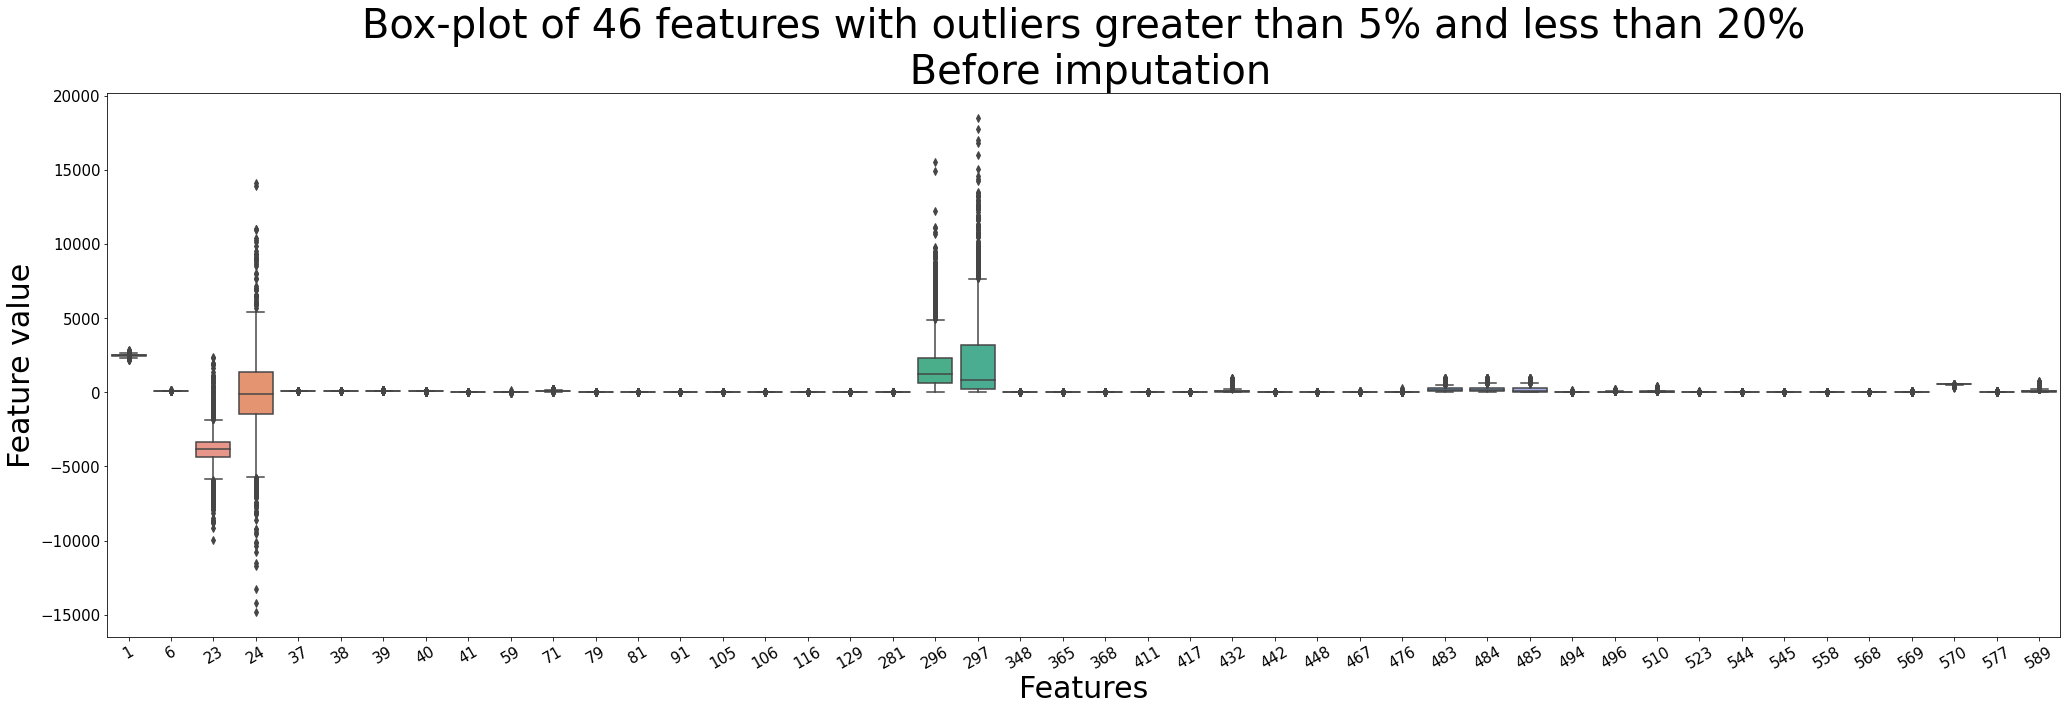

In [48]:
#Generate box-plot for the outliers greater than 5% and less than 20% 
plt.figure(figsize=(35,10))
sns.boxplot(data=signalFilteredDropped2[outlier_gt_0]);
plt.xlabel('Features', fontsize=30) 
plt.ylabel('Feature value', fontsize=30)
plt.title("Box-plot of 46 features with outliers greater than 5% and less than 20%\n Before imputation", fontsize=40)
plt.xticks(rotation=30, fontsize=15)
plt.yticks(fontsize=15)
plt.show();

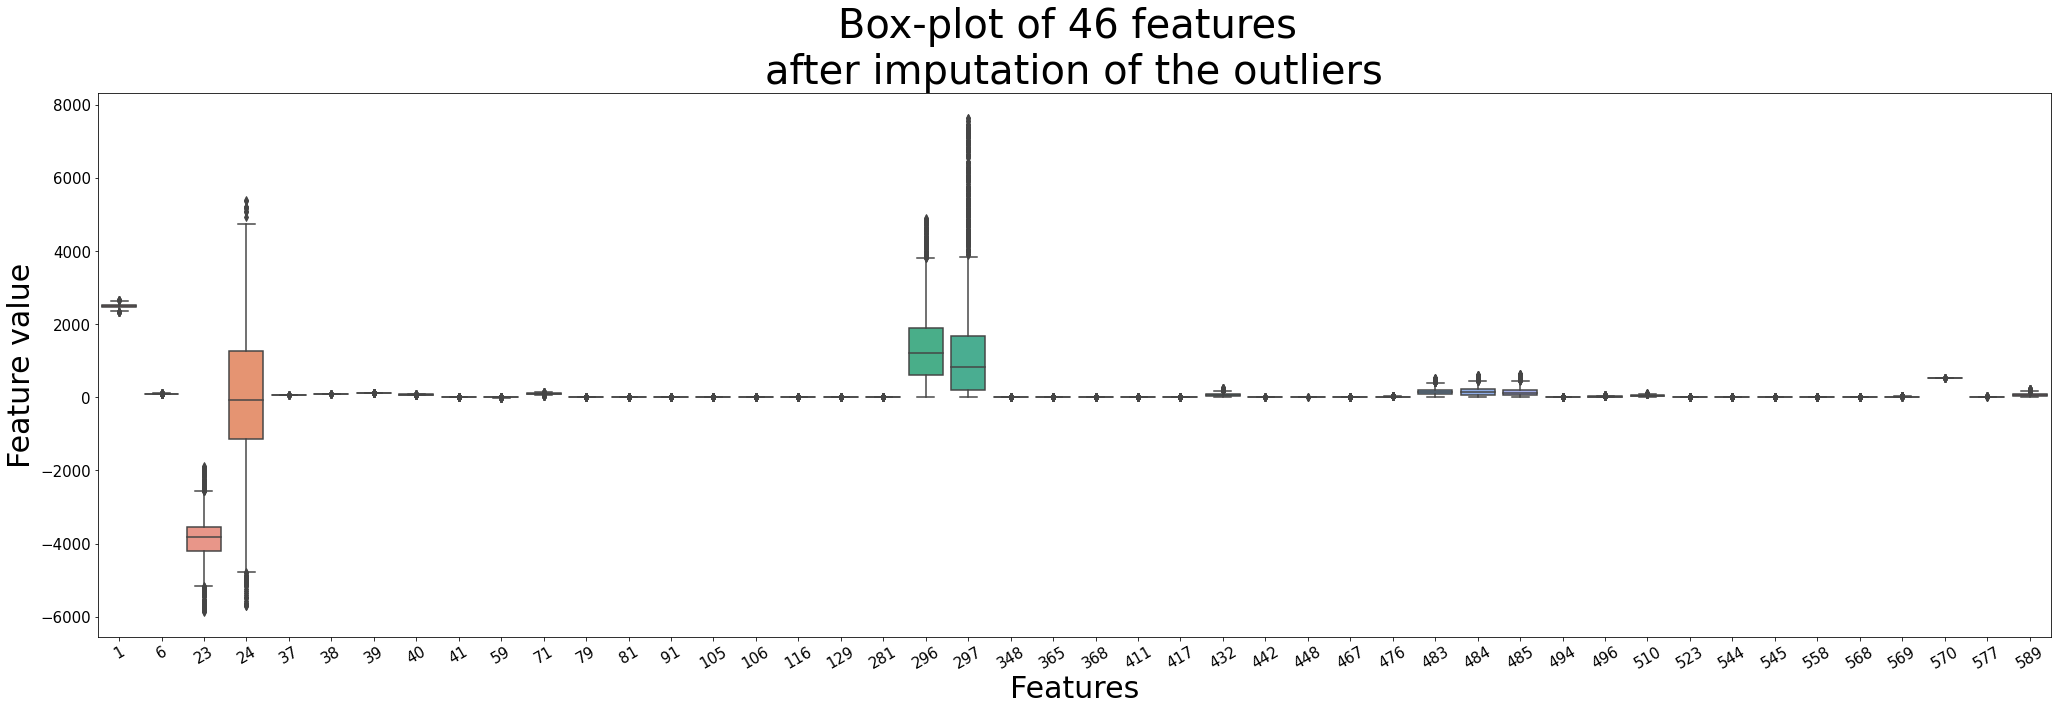

In [49]:
#Generate box-plot for the outliers greater than 5% and less than 20% 
plt.figure(figsize=(35,10))
sns.boxplot(data=signalFilteredDropped3[outlier_gt_0]);
plt.xlabel('Features', fontsize=30) 
plt.ylabel('Feature value', fontsize=30)
plt.title("Box-plot of 46 features \nafter imputation of the outliers", fontsize=40)
plt.xticks(rotation=30, fontsize=15)
plt.yticks(fontsize=15)
plt.show();

**<span style="color:blue">Observations</span>**

- A total of 46 features are reported with outliers greater than 5% and less than 20%. A box-plot generated for the same shows feature values on the y-axis with a range of -15000 to +20000.
- The 2nd box-plot is generated for the same 46 features after imputing the outliers with their respective median values. It is observed that the scale of the feature values on the y-axis has been reduced to -6000 to +8000, proving that the imputation of outliers is successful.

### Boxplot for features with <5% outliers for first 85 features

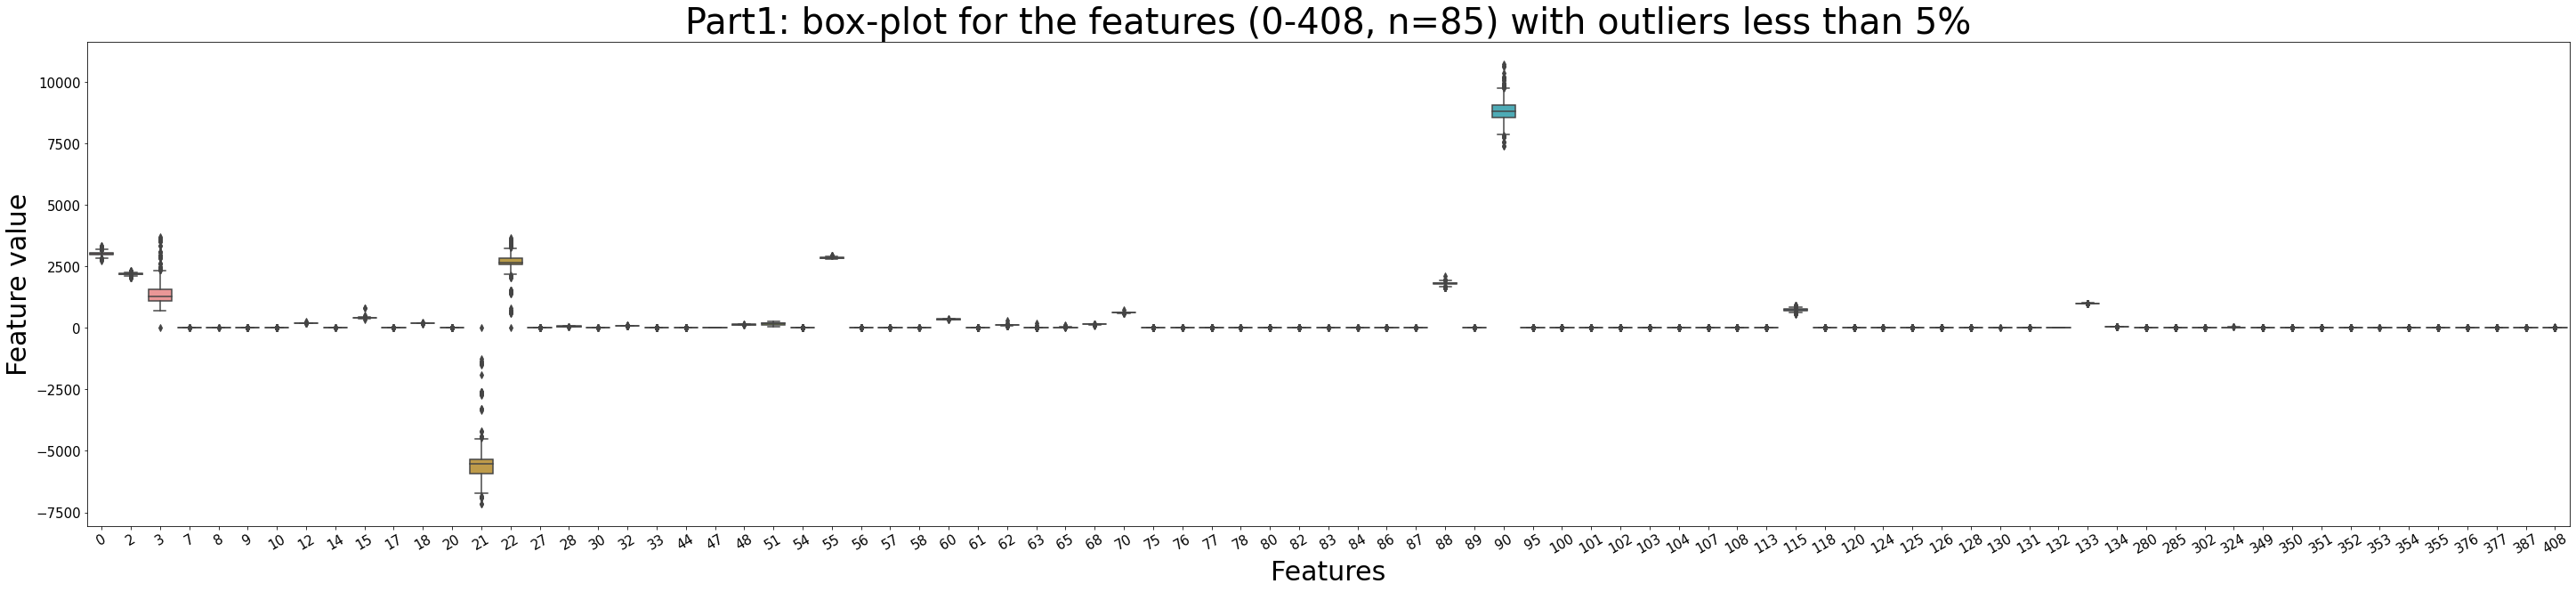

In [50]:
#Generate box-plot for the 1st set of split features with outliers less than 5% 
outlier_lt_5 = signalFilteredDropped3.drop(labels= outlier_gt_0 , axis = 1)
outlier_lt_5['Category'] = ""
outlier_lt_5.loc[outlier_lt_5["Pass/Fail"] == -1, 'Category'] = "Pass"
outlier_lt_5.loc[outlier_lt_5["Pass/Fail"] == 1, 'Category'] = "Fail"
plt.figure(figsize=(50,10))
sns.boxplot(data=outlier_lt_5[list(outlier_lt_5.columns)[0:85]]);
plt.xlabel('Features', fontsize=30) 
plt.ylabel('Feature value', fontsize=30)
plt.title("Part1: box-plot for the features (0-408, n=85) with outliers less than 5%", fontsize=40)
plt.xticks(rotation=30, fontsize=15)
plt.yticks(fontsize=15)
plt.show();

### Boxplot for features with <5% outliers for remaining 83 features

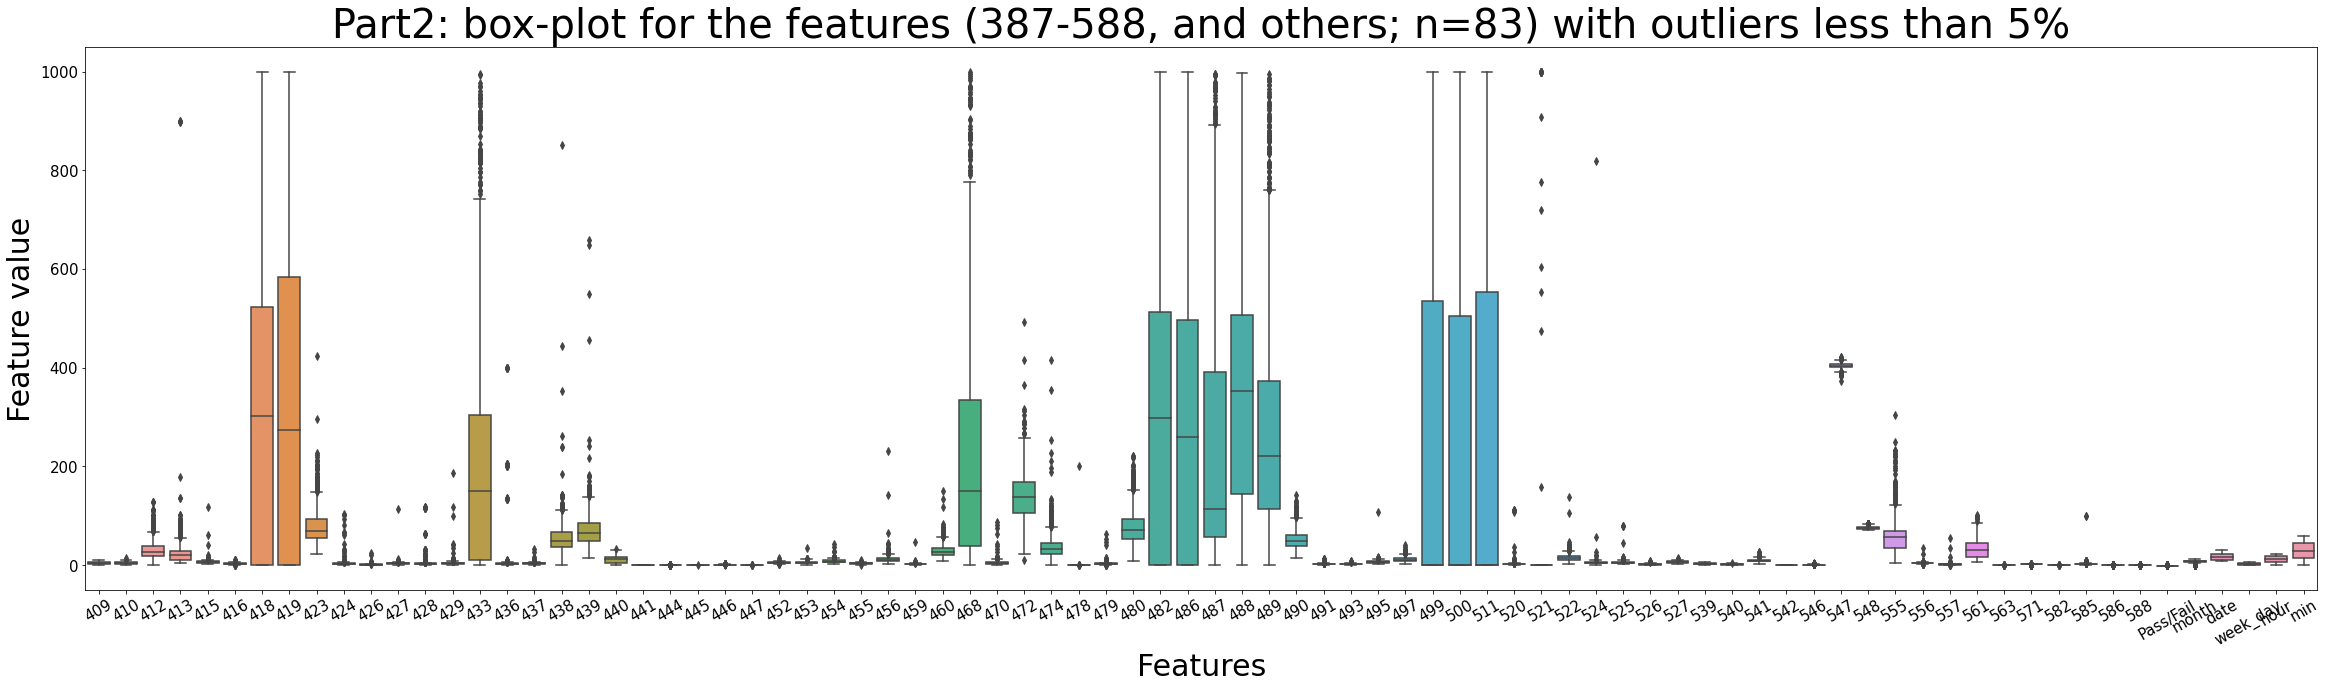

In [51]:
#Generate box-plot for the 2nd set of split features with outliers less than 5% 
plt.figure(figsize=(40,10))
sns.boxplot(data=outlier_lt_5[list(outlier_lt_5.columns)[85:172]]);
#sns.bxoxplot(data=outlier_lt_5, x='0', hue="Category");
plt.xlabel('Features', fontsize=30) 
plt.ylabel('Feature value', fontsize=30)
plt.title("Part2: box-plot for the features (387-588, and others; n=83) with outliers less than 5%", fontsize=40)
plt.xticks(rotation=30, fontsize=15)
plt.yticks(fontsize=15)
plt.show();

### Check class wise distribution of selected features using boxplots

In [52]:
selected_features=["0","2","3","21","22","55","88","90","115","133","413","423","433","436","438","439","456","468","472","474","478","480","487","489","521","524","547","555"]

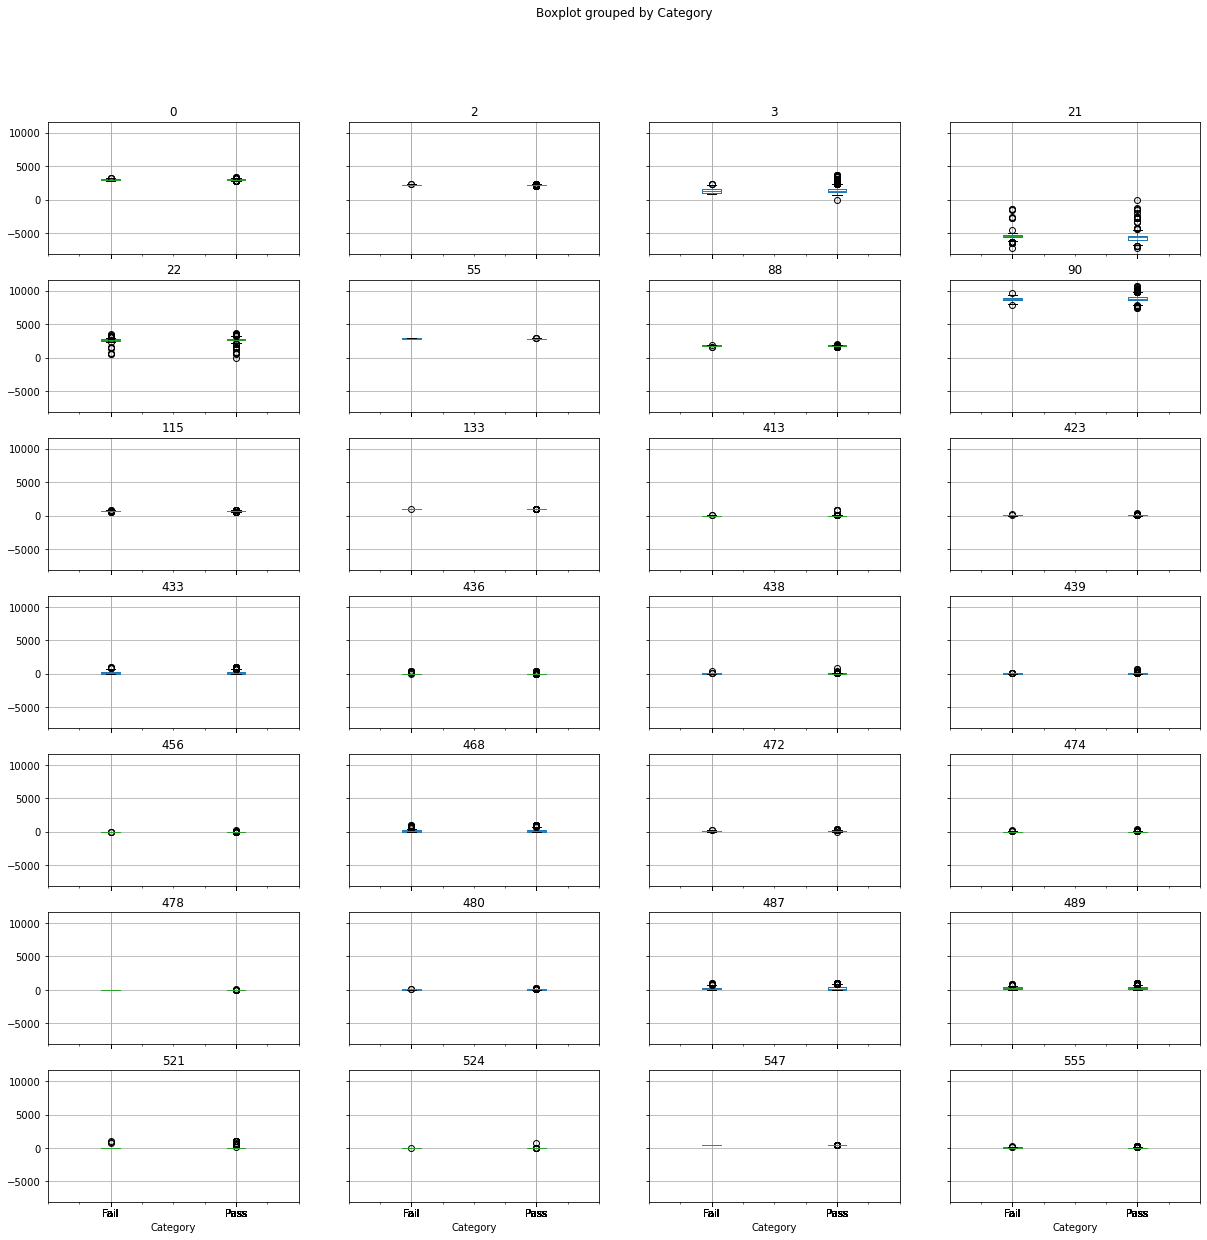

In [53]:
#Generate box-plot on the above selected features
outlier_lt_5.boxplot(column=selected_features, by='Category', figsize = (20,20), layout = (7,4));

**<span style="color:blue">Observations</span>**

- Based on these few selected features, we can not clearly see the variation in distributions of features among different classes i.e. Fail and Pass
- Let's apply Z-score based scaling on selected features and check if we observe any difference

In [54]:
outlier_lt_5_sc = outlier_lt_5
outlier_lt_5_sc[selected_features] = outlier_lt_5[selected_features].apply(zscore)

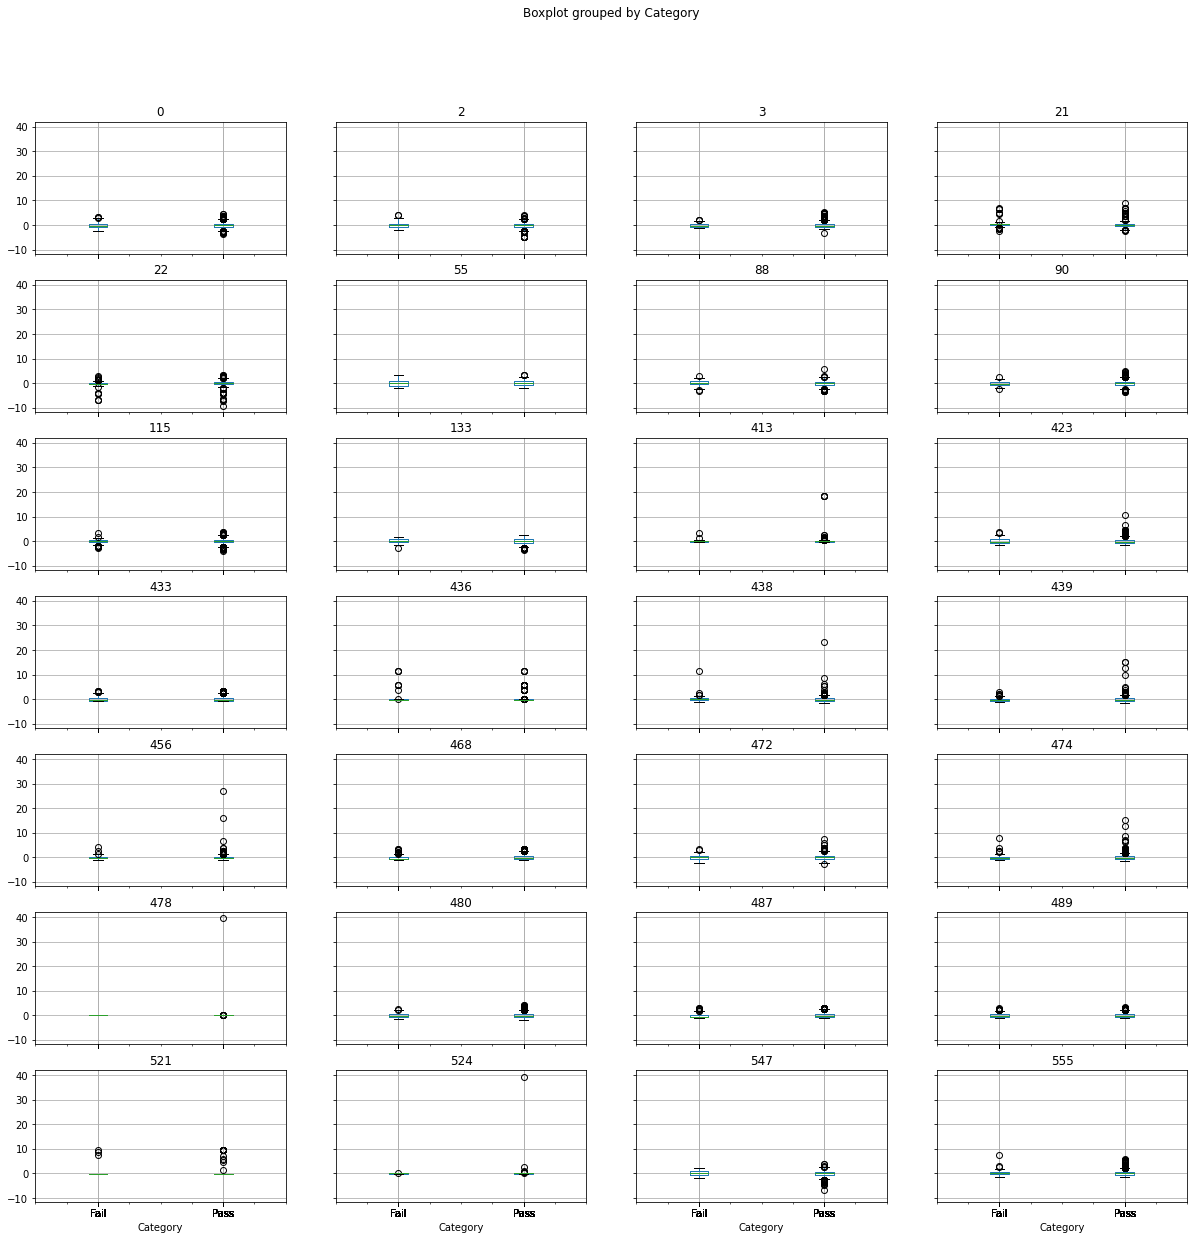

In [55]:
#Generate box-plot on the above selected features
outlier_lt_5_sc.boxplot(column=selected_features, by='Category', figsize = (20,20), layout = (7,4));

**<span style="color:blue">Observations</span>**

- After scaling of the selected features, some of the features (e.g. 413, 439, 456, etc.) show differences in the extent of distribution between two classes i.e. Fail/Pass

### Univariate analysis of time related features using distplots

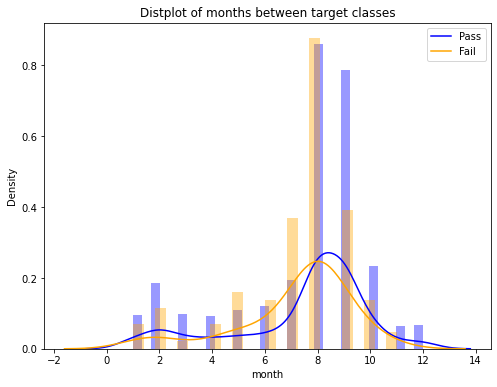

In [56]:
# Months
plt.figure(figsize=(8,6))
sns.distplot(signalFilteredDropped3[signalFilteredDropped3['Pass/Fail'] == -1]['month'], color = 'blue');
sns.distplot(signalFilteredDropped3[signalFilteredDropped3['Pass/Fail'] == 1]['month'], color = 'orange');
plt.title("Distplot of months between target classes")
plt.legend(['Pass', 'Fail'])
plt.show();

**<span style="color:blue">Observations</span>**
- It can be seen that the both Pass and Fail records peak in the month of August.
- August and September show higher production

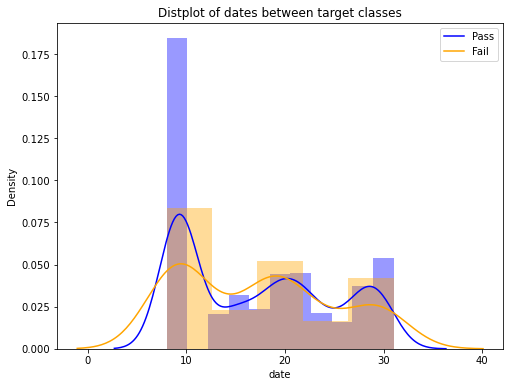

In [57]:
# Dates
plt.figure(figsize=(8,6))
sns.distplot(signalFilteredDropped3[signalFilteredDropped3['Pass/Fail'] == -1]['date'], color = 'blue');
sns.distplot(signalFilteredDropped3[signalFilteredDropped3['Pass/Fail'] == 1]['date'], color = 'orange');
plt.title("Distplot of dates between target classes")
plt.legend(['Pass', 'Fail'])
plt.show();

**<span style="color:blue">Observations</span>**
- It can be seen that the productions peaks in first 10 days of the month with relatively higher proportion of passed products

### Distribution of target classes using Pie chart

In [58]:
signalFilteredDropped3['Pass/Fail'].value_counts()

-1    1463
 1     104
Name: Pass/Fail, dtype: int64

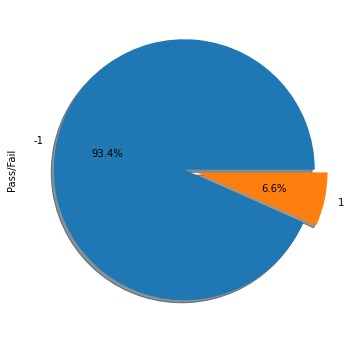

In [59]:
#Distribution of the frequency count of the target column(Pass/Fail)
plt.figure(figsize=(6,6))
signalFilteredDropped3['Pass/Fail'].value_counts().plot(kind='pie', legend=False, \
                   autopct='%1.1f%%', explode=(0, 0.1), \
                   shadow=True, startangle=0);

**<span style="color:blue">Observations</span>**

- This is a very imbalanced dataset where we see 93.4% Pass signal and 6.6% Fail signal.
- Dataset would be balanced in the subsequent part of the project i.e. dataset pre-processing.

### Perform bivariate and multivariate analysis and provide detailed comments after each analysis

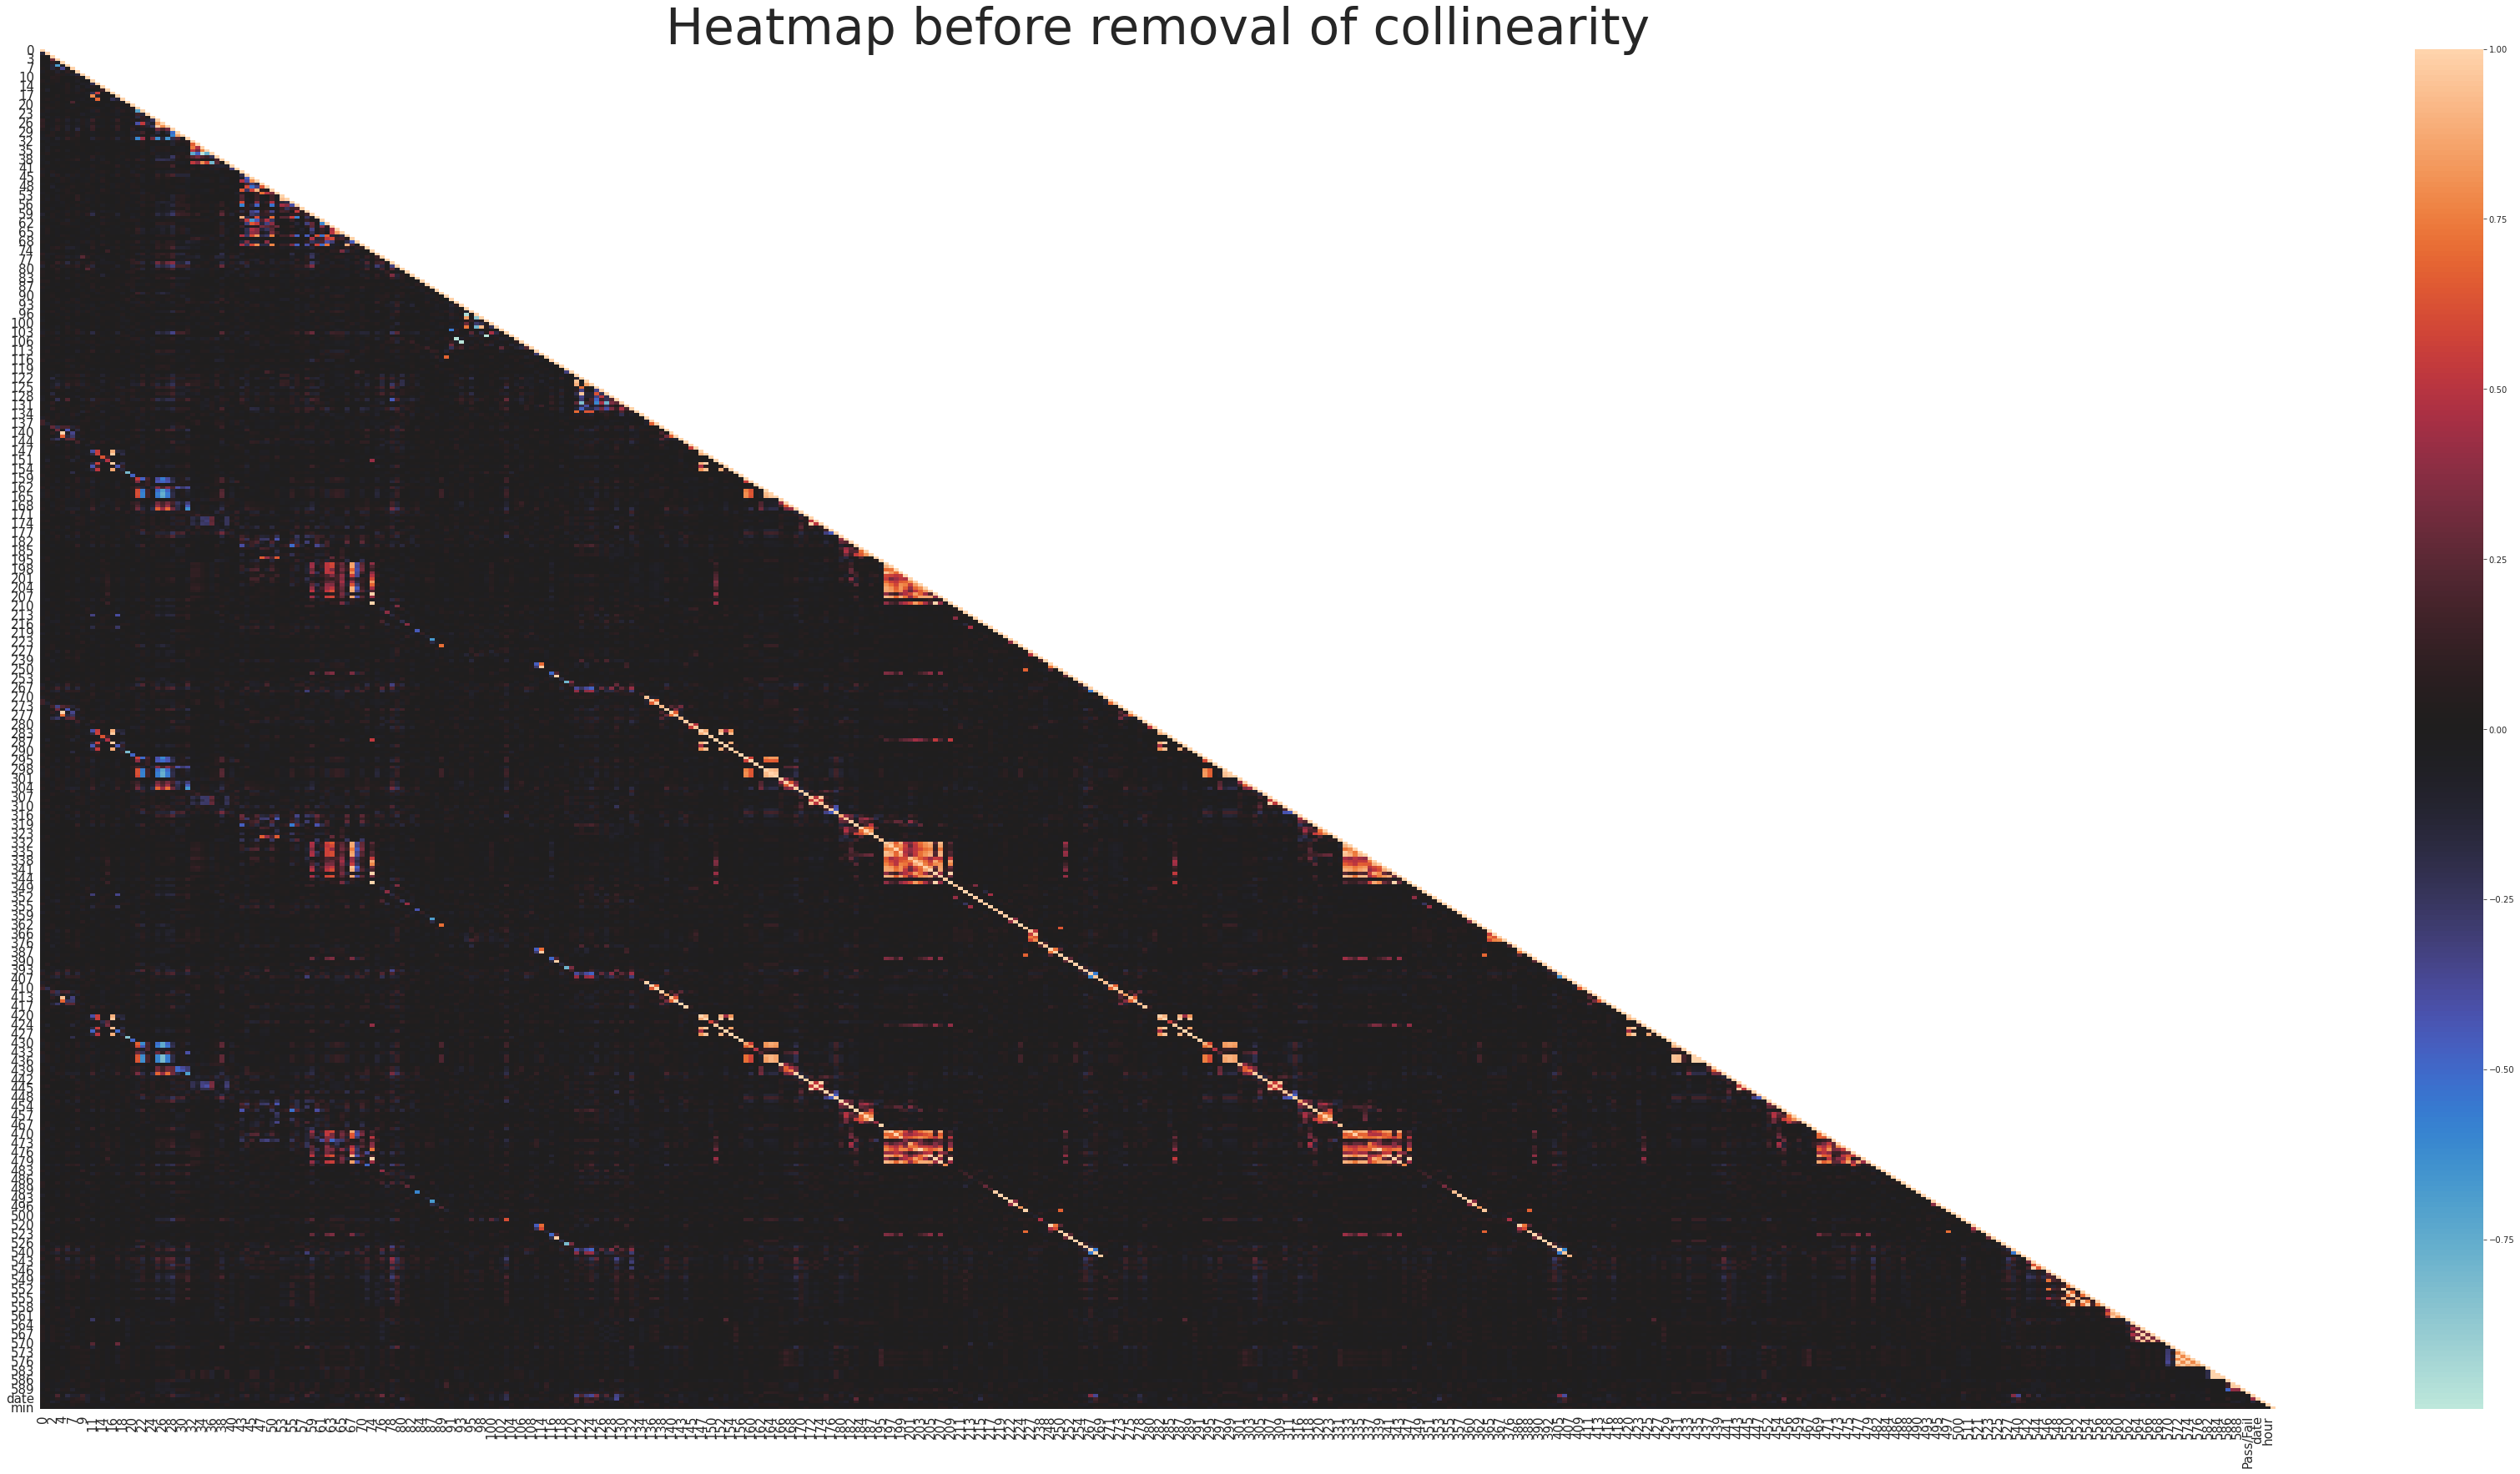

In [60]:
#Heatmap before removal of the highly collinear values
plt.figure(figsize=(60,30))
mask = np.zeros_like(signalFilteredDropped.corr())
mask[np.triu_indices_from(mask, 1)] = True # To plot only lower triangular matrix of the plot
with sns.axes_style("white"):
    sns.heatmap(signalFilteredDropped.corr(), annot=False, center = 0,  mask=mask)
plt.title("Heatmap before removal of collinearity", fontsize=60)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

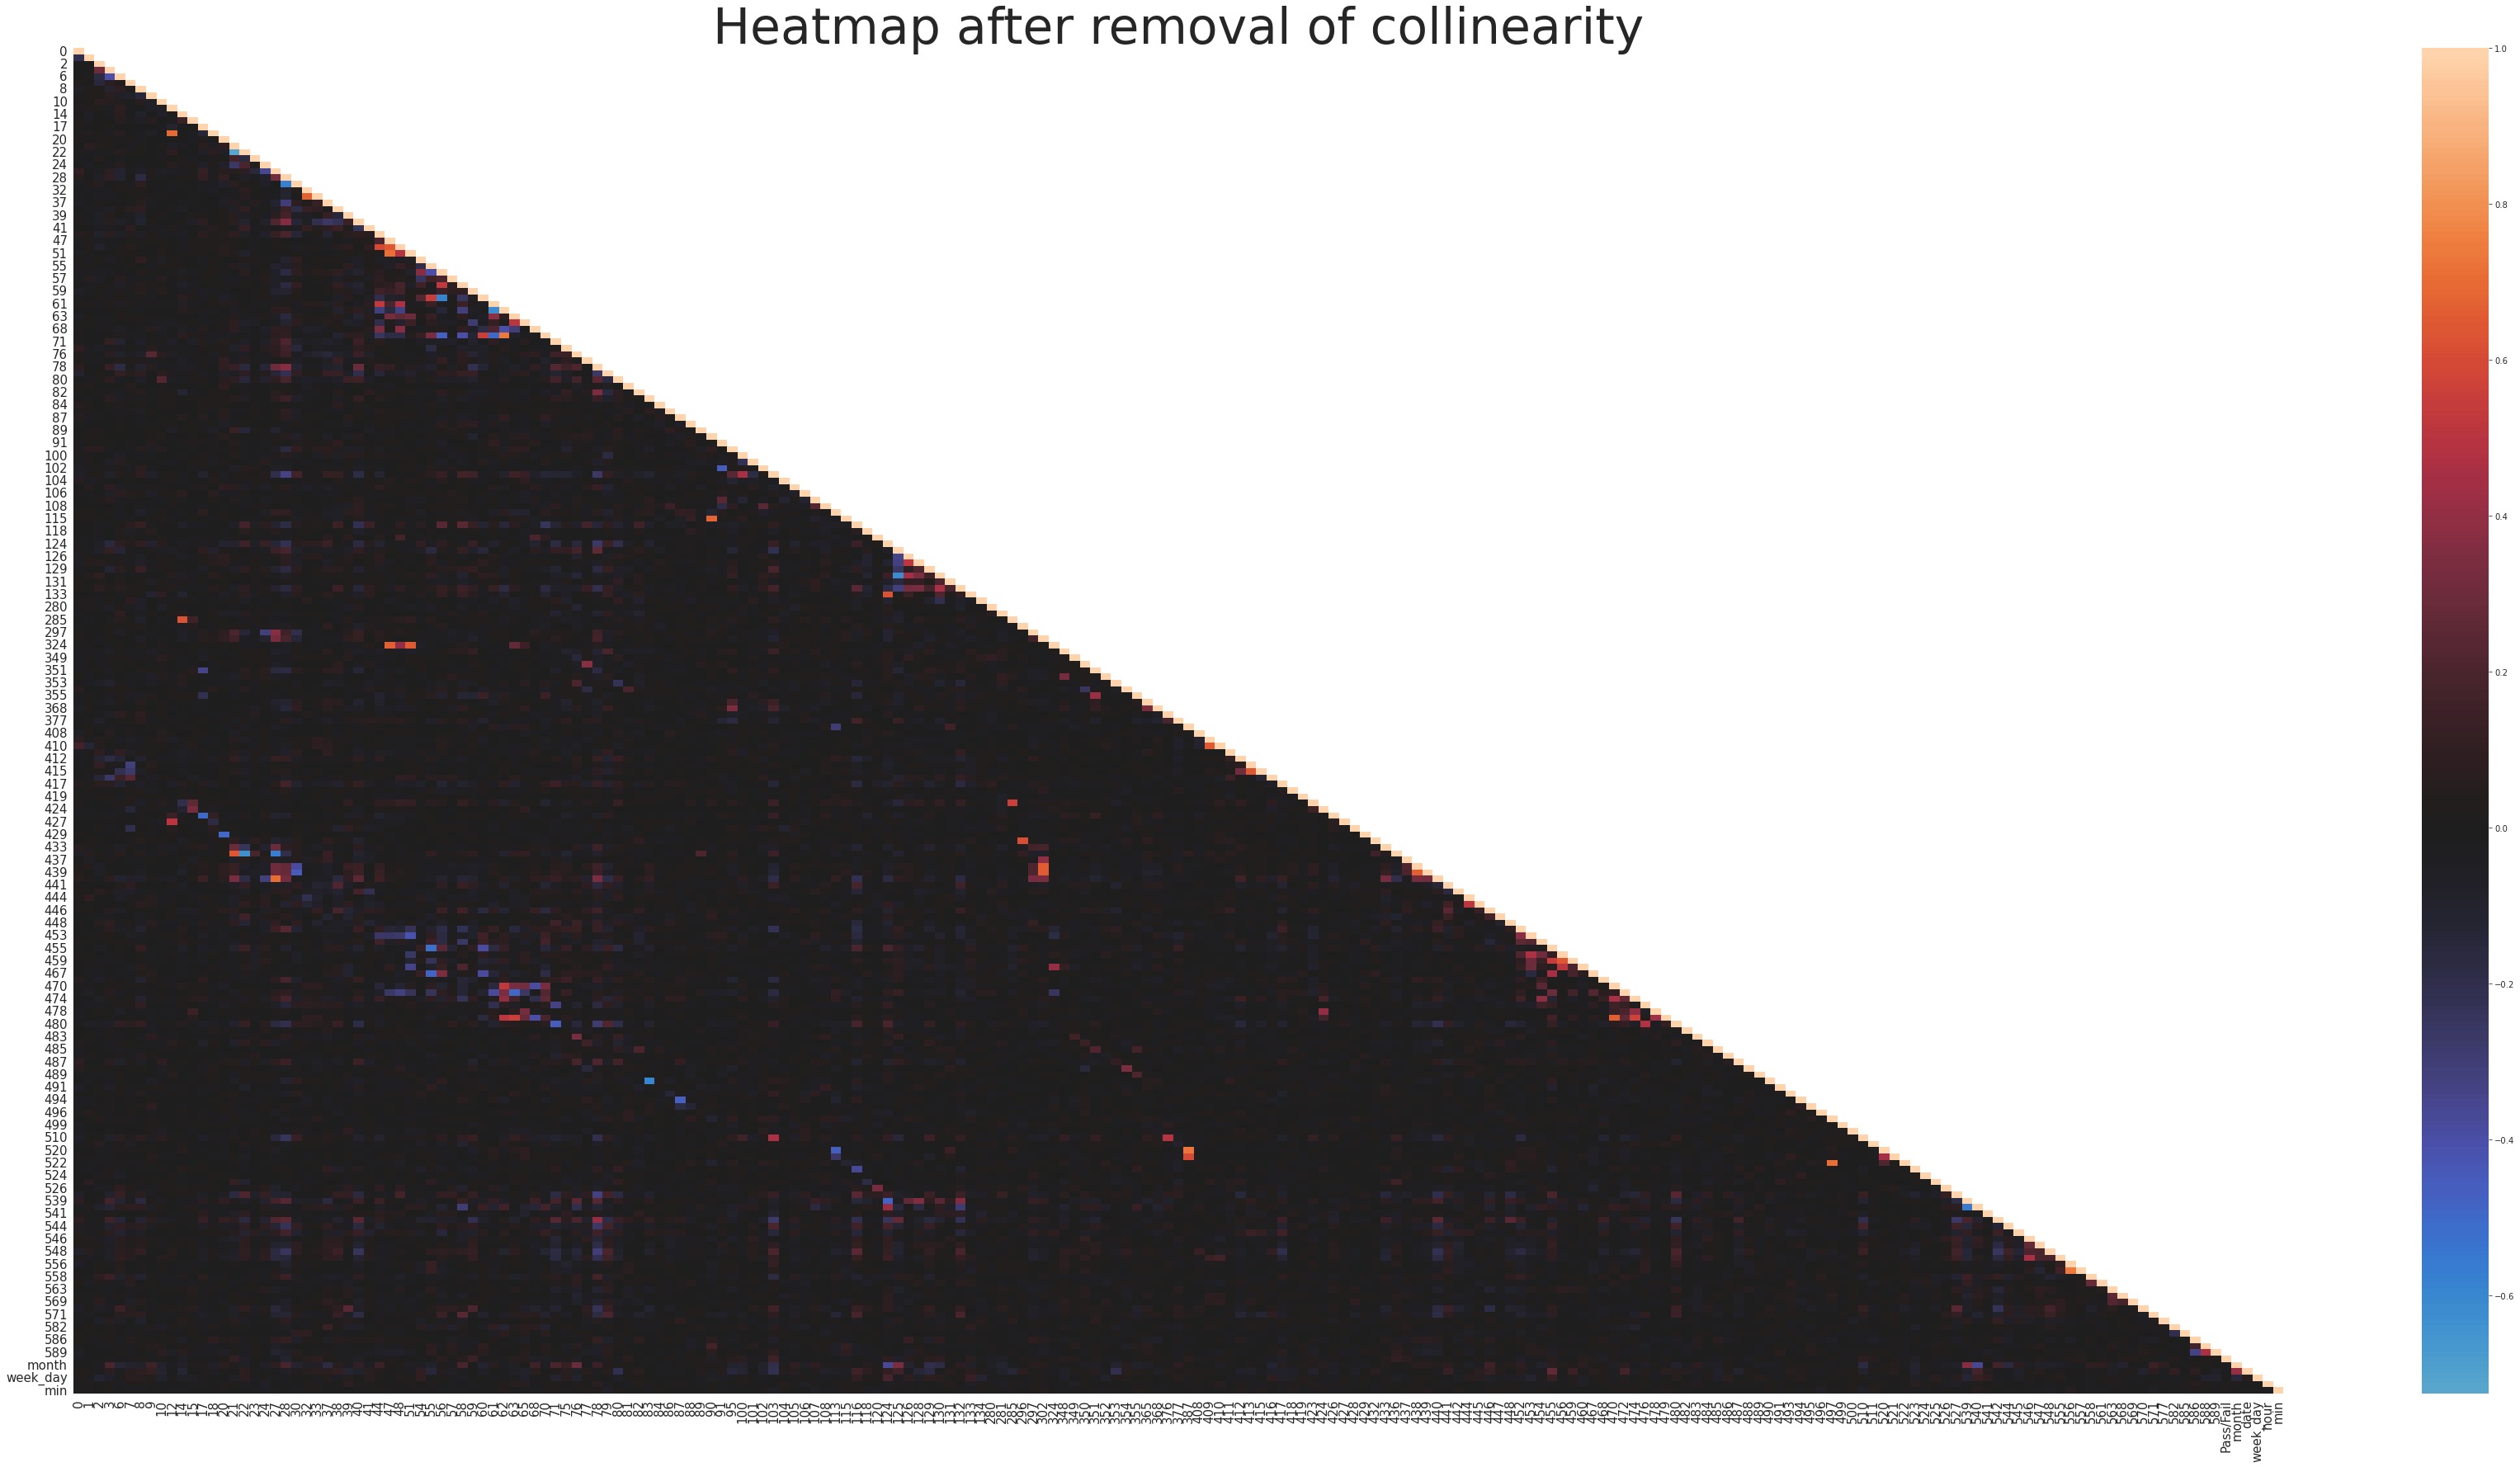

In [61]:
#Heatmap after removal of the highly collinear values
plt.figure(figsize=(60,30))
mask = np.zeros_like(signalFilteredDropped3.corr())
mask[np.triu_indices_from(mask, 1)] = True # To plot only lower triangular matrix of the plot
with sns.axes_style("white"):
    sns.heatmap(signalFilteredDropped3.corr(), annot=False, center = 0,  mask=mask)
plt.title("Heatmap after removal of collinearity", fontsize=60)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

**<span style="color:blue">Observations</span>**
- The heatmap after removal of highly correlated features does not display much collinearity compared to the one before removal of correlated features.
- However we still see some red and blue blocks showing higher positive and negative correlation values.

### Pair plots of selected features

In [62]:
subFeatures = ["0","2","3","413","436","439","555", "month", "date"]
subDf = signalFilteredDropped3[subFeatures]
subDf.shape, outlier_lt_5.shape
subDf["Category"] = outlier_lt_5['Category']

<Figure size 720x720 with 0 Axes>

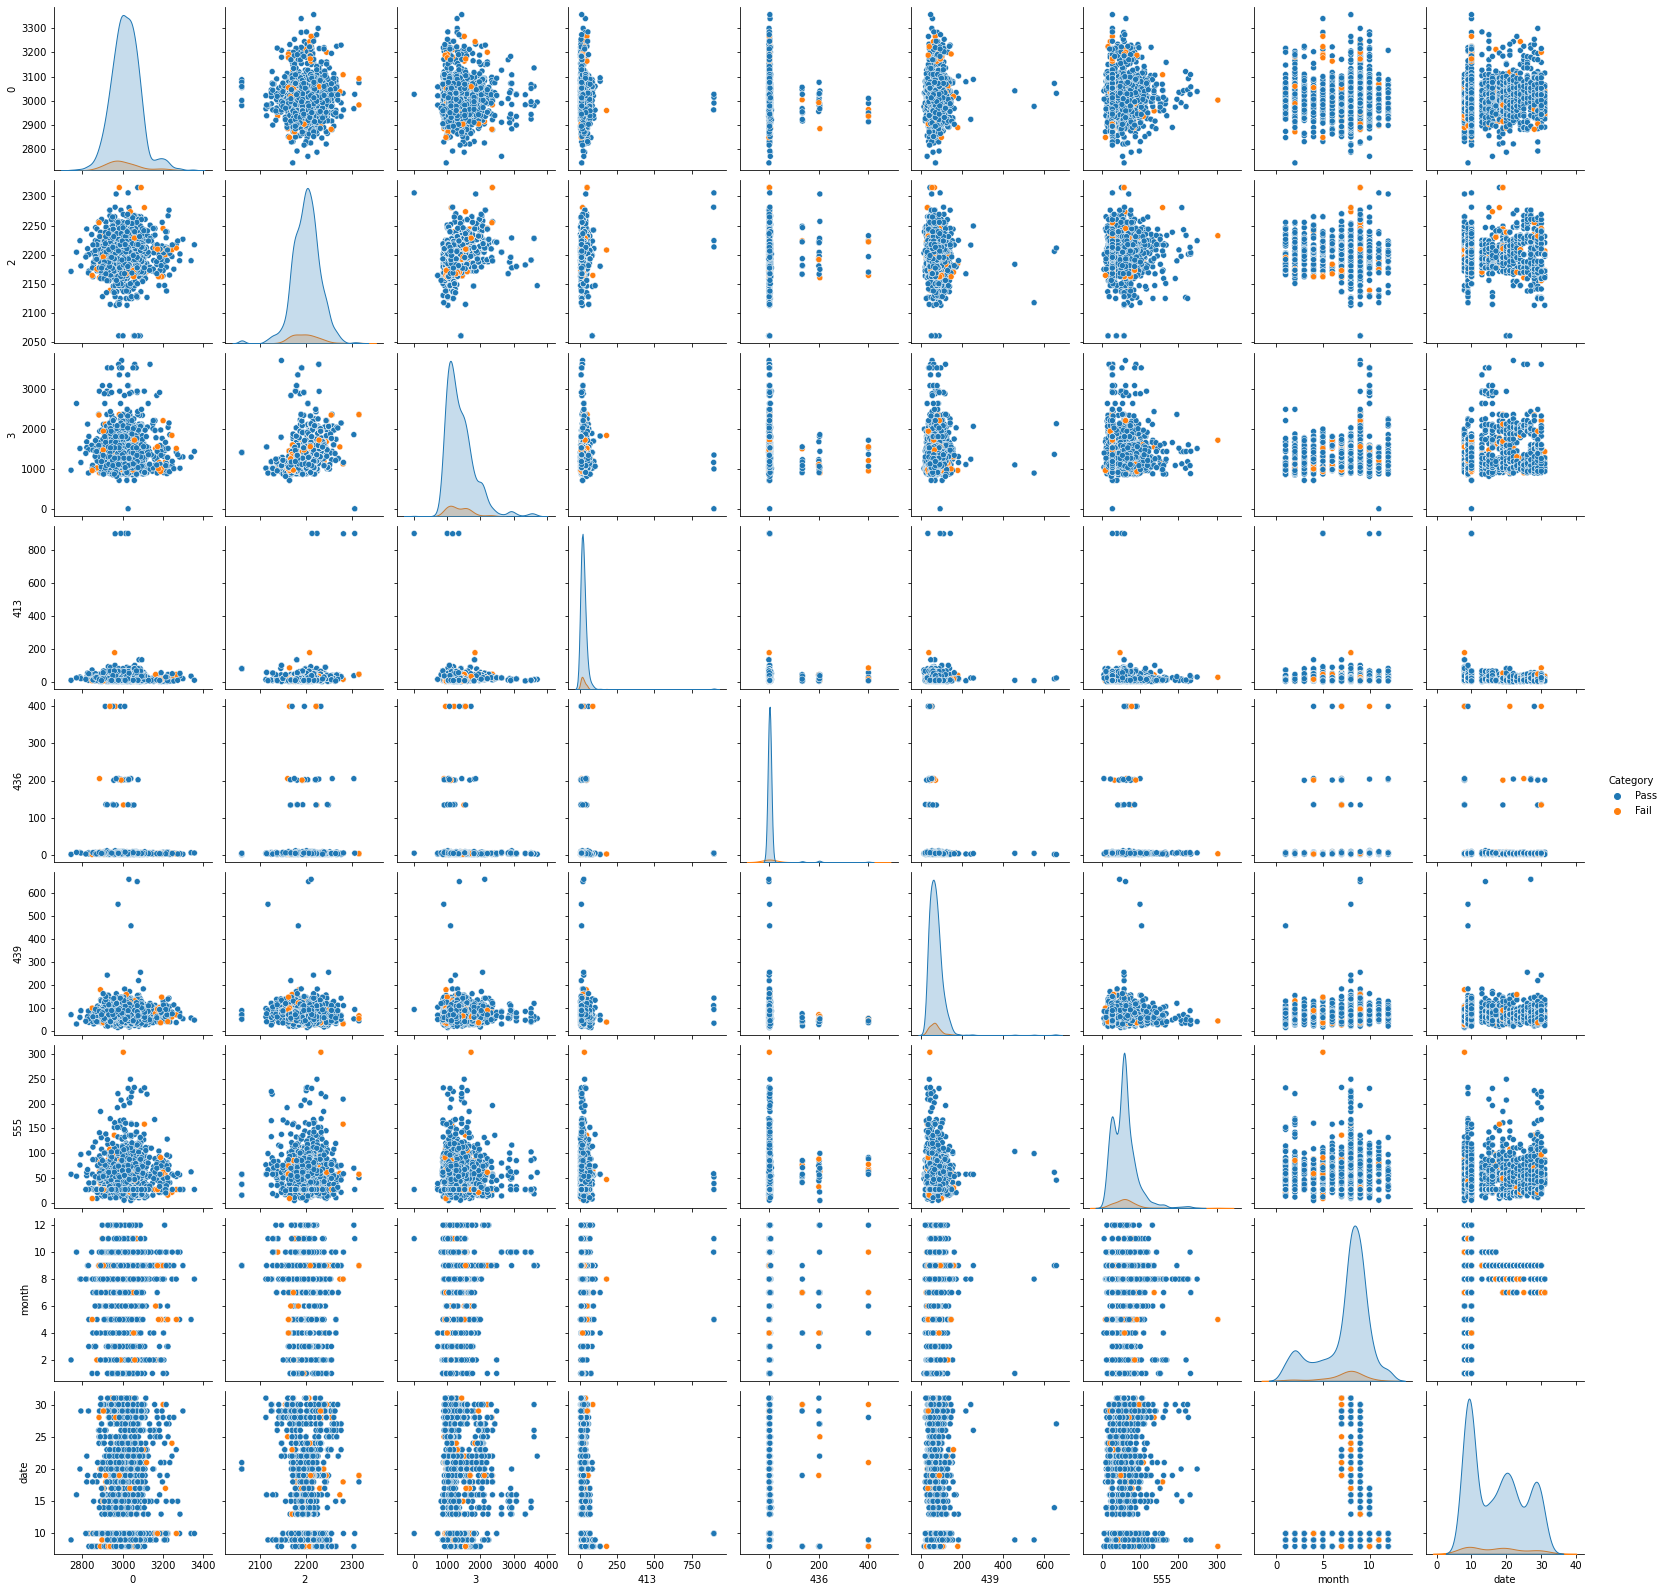

In [63]:
plt.figure(figsize=(10,10))
sns.pairplot(data=subDf, hue="Category", diag_kind='kde');
plt.show();

**<span style="color:blue">Observations</span>**
- KDE plots clearly shows the imbalance in the classes of data, dominated by "Pass" records
- Some of the features are right skewed (e.g. 3), some are multi-modal (e.g. 555, date)
- Most features look uncorrelated after removal of collinearity in the data
- In some scatter plots (e.g. 0 Vs 439), the "Fail" records are on either ends of the distribution

## Data pre-processing

### Segregate predictors vs target attributes

In [64]:
# Predictors
X = signalFilteredDropped3.drop(labels= ["Pass/Fail"] , axis = 1)
# Target
y = signalFilteredDropped3["Pass/Fail"]
print("shape of X:", X.shape)
print("shape of y:", y.shape)

shape of X: (1567, 212)
shape of y: (1567,)


### Check for target balancing and fix it if found imbalanced

In [65]:
#Check the count of target classes, Pass(-1) and Fail(1) 
signalFilteredDropped3["Pass/Fail"].value_counts()

-1    1463
 1     104
Name: Pass/Fail, dtype: int64

**<span style="color:blue">Observations</span>**

- It can be observed that data is highly imbalanced with majority of the records from "Pass" category
- Let's apply SMOTE technique to balance the data set

In [66]:
#Apply SMOTE technique to balance the dataset
sm = SMOTE(sampling_strategy= 'auto', random_state= 1 )
X, y = sm.fit_resample(X, y)

In [67]:
# Confirm the distribution of classes after balancing
y.value_counts()

-1    1463
 1    1463
Name: Pass/Fail, dtype: int64

### Perform train-test split and standardise the data or vice versa if required

In [68]:
#Split data into train and test with 70:30 proportion
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2048, 212), (878, 212), (2048,), (878,))

In [69]:
X_train.shape

(2048, 212)

**<span style="color:blue">Comments</span>**

- Cyclic or time specific features need to be standardised separately. (Reference: [here](https://www.kaggle.com/code/avanwyk/encoding-cyclical-features-for-deep-learning))
- We will segregate features between numeric and cyclic/time-related features for standardization/scaling purpose


In [70]:
cyclicFeatures_X_train = X_train[['month', 'date', 'week_day', 'hour', 'min']]
numericFeatures_X_train = X_train.drop(columns=['month', 'date', 'week_day', 'hour', 'min'])

In [71]:
cyclicFeatures_X_test = X_test[['month', 'date', 'week_day', 'hour', 'min']]
numericFeatures_X_test = X_test.drop(columns=['month', 'date', 'week_day', 'hour', 'min'])

In [72]:
cyclicFeatures_X_train.shape, numericFeatures_X_train.shape

((2048, 5), (2048, 207))

In [73]:
cyclicFeatures_X_test.shape, numericFeatures_X_test.shape

((878, 5), (878, 207))

In [74]:
numericFeatures_X_train_scaled = numericFeatures_X_train.apply(zscore)

In [75]:
numericFeatures_X_test_scaled = numericFeatures_X_test.apply(zscore)

In [76]:
# Function to encode cyclic features
def encodeCyclicFeature(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

### Scale cyclic features for training data set

In [77]:
cyclicFeatures_X_train_scaled = encodeCyclicFeature(cyclicFeatures_X_train.copy(), 'month', 12)
cyclicFeatures_X_train_scaled = encodeCyclicFeature(cyclicFeatures_X_train_scaled, 'date', 31)
cyclicFeatures_X_train_scaled = encodeCyclicFeature(cyclicFeatures_X_train_scaled, 'week_day', 6)
cyclicFeatures_X_train_scaled = encodeCyclicFeature(cyclicFeatures_X_train_scaled, 'hour', 23)
cyclicFeatures_X_train_scaled = encodeCyclicFeature(cyclicFeatures_X_train_scaled, 'min', 59)
cyclicFeatures_X_train_scaled.drop(columns=['month', 'date', 'week_day', 'hour', 'min'], inplace=True)

In [78]:
cyclicFeatures_X_train_scaled

,month_sin,month_cos,date_sin,date_cos,week_day_sin,week_day_cos,hour_sin,hour_cos,min_sin,min_cos
2011,-0.866025,-5.000000e-01,-0.897805,-0.440394,1.224647e-16,-1.0,-0.398401,-0.917211,0.957422,0.288692
1587,-1.000000,-1.836970e-16,0.897805,-0.440394,8.660254e-01,0.5,-0.730836,0.682553,0.716457,-0.697632
220,-0.866025,-5.000000e-01,-0.101168,-0.994869,-8.660254e-01,0.5,-0.631088,-0.775711,-0.053222,-0.998583
2232,-0.866025,-5.000000e-01,-0.485302,-0.874347,-8.660254e-01,-0.5,0.631088,-0.775711,-0.678312,0.734774
2755,-0.866025,-5.000000e-01,-0.101168,-0.994869,-8.660254e-01,0.5,-0.997669,-0.068242,0.957422,0.288692
...,...,...,...,...,...,...,...,...,...,...
1638,-0.500000,-8.660254e-01,0.998717,-0.050649,-8.660254e-01,-0.5,-0.136167,-0.990686,-0.638244,-0.769834
1095,-1.000000,-1.836970e-16,-0.848644,0.528964,-8.660254e-01,-0.5,0.519584,0.854419,0.364161,-0.931336
1130,-1.000000,-1.836970e-16,-0.724793,0.688967,-8.660254e-01,0.5,-0.631088,-0.775711,0.106293,0.994335
1294,0.866025,-5.000000e-01,0.897805,-0.440394,1.224647e-16,-1.0,-0.979084,0.203456,0.999646,-0.026621


### Scale cyclic features for test data set

In [79]:
cyclicFeatures_X_test_scaled = encodeCyclicFeature(cyclicFeatures_X_test.copy(), 'month', 12)
cyclicFeatures_X_test_scaled = encodeCyclicFeature(cyclicFeatures_X_test_scaled, 'date', 31)
cyclicFeatures_X_test_scaled = encodeCyclicFeature(cyclicFeatures_X_test_scaled, 'week_day', 6)
cyclicFeatures_X_test_scaled = encodeCyclicFeature(cyclicFeatures_X_test_scaled, 'hour', 23)
cyclicFeatures_X_test_scaled = encodeCyclicFeature(cyclicFeatures_X_test_scaled, 'min', 59)
cyclicFeatures_X_test_scaled.drop(columns=['month', 'date', 'week_day', 'hour', 'min'], inplace=True)

In [80]:
cyclicFeatures_X_test_scaled

,month_sin,month_cos,date_sin,date_cos,week_day_sin,week_day_cos,hour_sin,hour_cos,min_sin,min_cos
1048,-1.000000,-1.836970e-16,-0.988468,0.151428,8.660254e-01,-0.5,0.730836,0.682553,-0.263103,-0.964768
1210,0.500000,8.660254e-01,0.897805,-0.440394,1.224647e-16,-1.0,0.519584,0.854419,-0.596367,0.802712
1014,-1.000000,-1.836970e-16,-0.968077,-0.250653,0.000000e+00,1.0,-0.631088,-0.775711,-0.638244,-0.769834
2510,-1.000000,-1.836970e-16,-0.790776,-0.612106,1.224647e-16,-1.0,-0.979084,0.203456,0.982684,0.185289
679,0.866025,5.000000e-01,0.968077,-0.250653,-8.660254e-01,0.5,0.136167,-0.990686,-0.874763,0.484551
...,...,...,...,...,...,...,...,...,...,...
299,-0.866025,-5.000000e-01,-0.651372,-0.758758,8.660254e-01,0.5,0.631088,-0.775711,0.507666,0.861554
1178,-1.000000,-1.836970e-16,-0.394356,0.918958,0.000000e+00,1.0,-0.631088,-0.775711,0.413212,0.910635
1421,-0.866025,-5.000000e-01,0.897805,-0.440394,-2.449294e-16,1.0,-0.136167,-0.990686,0.921312,0.388824
1044,-1.000000,-1.836970e-16,-0.998717,-0.050649,8.660254e-01,0.5,-0.519584,0.854419,0.364161,-0.931336


#### Concatenate scaled numeric and cyclic features for train data

In [81]:
X_train_scaled = pd.concat([numericFeatures_X_train_scaled, cyclicFeatures_X_train_scaled], axis=1)

#### Concatenate scaled numeric and cyclic features for test data

In [82]:
X_test_scaled = pd.concat([numericFeatures_X_test_scaled, cyclicFeatures_X_test_scaled], axis=1)

In [83]:
# Shape of train and test data before scaling
X_train.shape, X_test.shape

((2048, 212), (878, 212))

In [84]:
# Shape of train and test data after scaling
X_train_scaled.shape, X_test_scaled.shape

((2048, 217), (878, 217))

**Note**:
- Please note that due to encoding of cyclic features, we created 5*2=10 features, and removed original/raw cyclic features

### Check if the train and test data have similar statistical characteristics when compared with original data

In [85]:
# Train Data before scaling
X_train.describe()

,0,1,2,3,6,7,8,9,10,12,...,582,585,586,588,589,month,date,week_day,hour,min
count,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,...,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000
mean,3011.505304,2495.337194,2200.664442,1370.083111,101.527942,0.121931,1.466219,-0.001867,0.000808,199.976462,...,0.500281,3.118641,0.021552,0.005452,78.920433,7.175293,17.229004,2.913086,11.782227,30.077637
std,71.276194,55.514936,27.212304,373.820878,4.030457,0.006836,0.062692,0.013343,0.008663,2.976117,...,0.003283,3.178008,0.011239,0.002617,42.582412,2.210256,6.963777,1.853255,6.336088,16.493735
min,2743.240000,2326.590000,2060.660000,711.025800,88.091100,0.000000,1.191000,-0.040800,-0.032900,182.094000,...,0.477800,1.197500,-0.016900,0.001000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000
25%,2962.445000,2459.545000,2181.853021,1107.324351,99.220000,0.121100,1.425979,-0.010100,-0.004457,198.343296,...,0.498200,2.367889,0.014200,0.003626,49.731599,6.000000,10.000000,1.000000,6.750000,16.000000
50%,3003.403042,2498.910000,2199.601042,1281.786200,101.492200,0.122200,1.467150,-0.001965,0.001300,199.710315,...,0.500400,2.825726,0.020811,0.005066,72.023000,8.000000,17.000000,3.000000,12.000000,30.000000
75%,3050.726183,2530.000858,2216.502775,1551.694700,103.920191,0.123486,1.508282,0.005916,0.006400,201.752058,...,0.502405,3.325292,0.027500,0.006642,96.894635,9.000000,22.000000,5.000000,17.000000,44.000000
max,3356.350000,2662.190000,2315.266700,3715.041700,113.883300,0.128600,1.653900,0.060900,0.053000,272.045100,...,0.509800,99.303200,0.102800,0.028600,220.037800,12.000000,31.000000,6.000000,23.000000,59.000000


In [86]:
# Train Data after scaling
X_train_scaled.describe()

,0,1,2,3,6,7,8,9,10,12,...,month_sin,month_cos,date_sin,date_cos,week_day_sin,week_day_cos,hour_sin,hour_cos,min_sin,min_cos
count,2.048000e+03,2.048000e+03,2.048000e+03,2.048000e+03,2.048000e+03,2.048000e+03,2.048000e+03,2.048000e+03,2.048000e+03,2.048000e+03,...,2.048000e+03,2.048000e+03,2048.000000,2048.000000,2048.000000,2048.000000,2.048000e+03,2048.000000,2048.000000,2048.000000
mean,-5.172837e-15,-1.593886e-15,-8.127288e-15,-4.600270e-16,1.787307e-15,3.453726e-16,2.770679e-15,3.469447e-18,2.005774e-18,1.204169e-15,...,-4.587439e-01,-3.557695e-01,-0.015985,-0.280398,0.013532,0.050293,-3.054881e-02,-0.074258,-0.004752,-0.036800
std,1.000244e+00,1.000244e+00,1.000244e+00,1.000244e+00,1.000244e+00,1.000244e+00,1.000244e+00,1.000244e+00,1.000244e+00,1.000244e+00,...,6.360973e-01,5.086120e-01,0.754541,0.593498,0.689486,0.722761,7.142120e-01,0.695657,0.730096,0.682694
min,-3.764663e+00,-3.040414e+00,-5.146151e+00,-1.763460e+00,-3.334640e+00,-1.784117e+01,-4.391105e+00,-2.918685e+00,-3.892121e+00,-6.010123e+00,...,-1.000000e+00,-1.000000e+00,-0.998717,-0.994869,-0.866025,-1.000000,-9.976688e-01,-0.990686,-0.999646,-0.998583
25%,-6.884807e-01,-6.448884e-01,-6.914525e-01,-7.030718e-01,-5.727652e-01,-1.215887e-01,-6.420297e-01,-6.172109e-01,-6.078989e-01,-5.488915e-01,...,-8.660254e-01,-8.660254e-01,-0.724793,-0.758758,-0.866025,-0.500000,-7.308360e-01,-0.775711,-0.716457,-0.697632
50%,-1.137019e-01,6.437328e-02,-3.908746e-02,-2.362588e-01,-8.870155e-03,3.936539e-02,1.485744e-02,-7.362252e-03,5.682896e-02,-8.944949e-02,...,-8.660254e-01,-5.000000e-01,-0.201299,-0.440394,0.000000,0.500000,-2.449294e-16,-0.068242,-0.053222,-0.026621
75%,5.504006e-01,6.245550e-01,5.821705e-01,4.859438e-01,5.936876e-01,2.275220e-01,6.711131e-01,5.834561e-01,6.457075e-01,5.967604e-01,...,1.224647e-16,-1.836970e-16,0.897805,-0.050649,0.866025,0.500000,7.308360e-01,0.682553,0.752571,0.574787
max,4.839328e+00,3.006282e+00,4.212442e+00,6.274479e+00,3.066246e+00,9.758254e-01,2.994446e+00,4.705416e+00,6.026441e+00,2.422157e+01,...,1.000000e+00,1.000000e+00,0.998717,1.000000,0.866025,1.000000,9.976688e-01,1.000000,0.999646,1.000000


In [87]:
# Test Data before scaling
X_test.describe()

,0,1,2,3,6,7,8,9,10,12,...,582,585,586,588,589,month,date,week_day,hour,min
count,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,...,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000
mean,3005.854308,2496.549846,2199.057168,1380.430109,101.298961,0.122078,1.467288,-0.001135,0.000643,199.792193,...,0.500456,2.973380,0.021231,0.005428,78.095344,7.174260,17.243736,2.951025,11.507973,29.673121
std,69.159390,55.062615,27.015028,370.828360,3.749168,0.006082,0.062801,0.013799,0.009133,2.320683,...,0.003247,0.932784,0.010996,0.002595,44.444830,2.271317,7.111575,1.858413,6.207496,16.698793
min,2787.490000,2329.660000,2060.660000,0.000000,88.091100,0.000000,1.200500,-0.053400,-0.034900,191.077700,...,0.490200,1.418200,-0.006000,0.001200,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000
25%,2959.898779,2467.258390,2180.872046,1108.945600,99.113300,0.121200,1.427900,-0.009394,-0.004794,198.336642,...,0.498215,2.356259,0.014031,0.003600,46.926429,6.000000,10.000000,1.000000,7.000000,16.000000
50%,2995.805018,2498.910000,2197.266700,1302.660700,101.492200,0.122269,1.467994,-0.001044,0.001387,199.526724,...,0.500611,2.797752,0.020842,0.005063,72.023000,8.000000,17.000000,3.000000,12.000000,29.500000
75%,3042.106676,2528.596790,2215.013138,1553.315800,103.559753,0.123500,1.507893,0.006871,0.006300,201.433300,...,0.502500,3.294291,0.027398,0.006538,100.413737,8.000000,23.000000,4.000000,16.000000,45.000000
max,3339.930000,2666.040000,2306.847494,3619.739700,112.581100,0.127600,1.656400,0.074900,0.039600,210.517900,...,0.509700,8.594600,0.102800,0.020800,220.037800,12.000000,31.000000,6.000000,23.000000,59.000000


In [88]:
# Test Data after scaling
X_test_scaled.describe()

,0,1,2,3,6,7,8,9,10,12,...,month_sin,month_cos,date_sin,date_cos,week_day_sin,week_day_cos,hour_sin,hour_cos,min_sin,min_cos
count,8.780000e+02,8.780000e+02,8.780000e+02,8.780000e+02,8.780000e+02,8.780000e+02,8.780000e+02,8.780000e+02,8.780000e+02,8.780000e+02,...,8.780000e+02,8.780000e+02,878.000000,878.000000,878.000000,878.000000,8.780000e+02,878.000000,8.780000e+02,878.000000
mean,2.110941e-15,7.332182e-15,8.628380e-15,1.445313e-16,3.940154e-15,-5.747072e-16,-4.567088e-15,-2.528982e-19,2.554272e-17,-4.990313e-16,...,-4.540213e-01,-3.393800e-01,-0.004645,-0.254255,0.002959,0.047267,1.418890e-02,-0.106133,7.044267e-03,-0.026448
std,1.000570e+00,1.000570e+00,1.000570e+00,1.000570e+00,1.000570e+00,1.000570e+00,1.000570e+00,1.000570e+00,1.000570e+00,1.000570e+00,...,6.398164e-01,5.197064e-01,0.761080,0.597626,0.676400,0.735784,7.144509e-01,0.692258,7.204126e-01,0.693827
min,-3.159206e+00,-3.032638e+00,-5.125889e+00,-3.724680e+00,-3.524885e+00,-2.008297e+01,-4.250597e+00,-3.789785e+00,-3.893984e+00,-3.757282e+00,...,-1.000000e+00,-1.000000e+00,-0.998717,-0.994869,-0.866025,-1.000000,-9.976688e-01,-0.990686,-9.996456e-01,-0.998583
25%,-6.648659e-01,-5.322695e-01,-6.735320e-01,-7.325201e-01,-5.833044e-01,-1.444456e-01,-6.275526e-01,-5.989010e-01,-5.955727e-01,-6.275653e-01,...,-8.660254e-01,-8.660254e-01,-0.724793,-0.758758,-0.866025,-0.500000,-7.308360e-01,-0.775711,-7.164567e-01,-0.697632
50%,-1.453890e-01,4.288753e-02,-6.631451e-02,-2.098376e-01,5.157133e-02,3.149106e-02,1.123635e-02,6.542258e-03,8.152026e-02,-1.144576e-01,...,-8.660254e-01,-5.000000e-01,-0.201299,-0.440394,0.000000,0.500000,-2.449294e-16,-0.334880,-1.224647e-16,-0.026621
75%,5.244845e-01,5.823408e-01,5.909698e-01,4.664806e-01,6.033553e-01,2.339258e-01,6.469312e-01,5.804643e-01,6.198171e-01,7.075689e-01,...,1.224647e-16,-1.836970e-16,0.897805,-0.050649,0.866025,0.500000,7.308360e-01,0.460065,7.525708e-01,0.658511
max,4.833271e+00,3.079889e+00,3.992288e+00,6.042110e+00,3.010953e+00,9.084139e-01,3.013018e+00,5.513286e+00,4.268108e+00,4.624424e+00,...,1.000000e+00,1.000000e+00,0.998717,1.000000,0.866025,1.000000,9.976688e-01,1.000000,9.996456e-01,1.000000


**<span style="color:blue">Observations</span>**
- It can be seen that, after scaling/standardisation of data, the mean of the data has become close to zero and standrad deviation close to 1 for numerical features in train and test sets

## Model training, testing and tuning

### Use any Supervised Learning technique to train a model

In [89]:
# Apply K-Nearest Neighbor Classifer to train a model
NNH = KNeighborsClassifier(n_neighbors = 5)

In [90]:
knn_base_model = NNH.fit(X_train_scaled, y_train)
y_predict_knn_base = knn_base_model.predict(X_test_scaled)
knn_base_model_train_score = knn_base_model.score(X_train_scaled, y_train)
knn_base_model_test_score = knn_base_model.score(X_test_scaled, y_test)
print("\nknn base model train score:", knn_base_model_train_score)
print("\nknn base model test score:", knn_base_model_test_score)
print("\nknn base model confusion matrix\n", metrics.confusion_matrix(y_test, y_predict_knn_base))
print("\nknn base model classification report\n", metrics.classification_report(y_test, y_predict_knn_base))


knn base model train score: 0.64599609375

knn base model test score: 0.5558086560364465

knn base model confusion matrix
 [[ 59 390]
 [  0 429]]

knn base model classification report
               precision    recall  f1-score   support

          -1       1.00      0.13      0.23       449
           1       0.52      1.00      0.69       429

    accuracy                           0.56       878
   macro avg       0.76      0.57      0.46       878
weighted avg       0.77      0.56      0.45       878



### Use cross validation techniques

In [91]:
# Apply k-fold cross validation technique to predict the accuracy
num_folds = 50
kfold = KFold(n_splits=num_folds)
results = cross_val_score(NNH,X_train_scaled , y_train, cv=kfold)
print(results)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

[0.48780488 0.53658537 0.46341463 0.56097561 0.46341463 0.51219512
 0.51219512 0.70731707 0.48780488 0.56097561 0.65853659 0.65853659
 0.58536585 0.63414634 0.56097561 0.6097561  0.68292683 0.65853659
 0.58536585 0.46341463 0.51219512 0.68292683 0.48780488 0.63414634
 0.6097561  0.53658537 0.6097561  0.58536585 0.75609756 0.53658537
 0.68292683 0.51219512 0.51219512 0.75609756 0.6097561  0.36585366
 0.58536585 0.53658537 0.53658537 0.51219512 0.46341463 0.56097561
 0.6097561  0.70731707 0.63414634 0.6097561  0.65853659 0.6097561
 0.6        0.6       ]
Accuracy: 58.010% (8.136%)


In [92]:
# Apply Leave one out cross validation technique to predict the accuracy
loo = LeaveOneOut()
results = cross_val_score(NNH,X_train_scaled , y_train, cv=loo)
print(results)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

[1. 1. 0. ... 0. 0. 0.]
Accuracy: 58.008% (49.355%)


In [93]:
#Apply Stratified cross validation technique to predict the accuracy
num_folds = 50
skf = StratifiedKFold(n_splits=num_folds)
results = cross_val_score(NNH,X_train_scaled , y_train, cv=skf)
print(results)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

[0.58536585 0.56097561 0.51219512 0.56097561 0.53658537 0.56097561
 0.6097561  0.56097561 0.6097561  0.58536585 0.63414634 0.63414634
 0.6097561  0.56097561 0.58536585 0.6097561  0.63414634 0.63414634
 0.51219512 0.53658537 0.58536585 0.58536585 0.6097561  0.6097561
 0.65853659 0.53658537 0.58536585 0.63414634 0.58536585 0.65853659
 0.56097561 0.68292683 0.58536585 0.56097561 0.58536585 0.56097561
 0.51219512 0.56097561 0.53658537 0.48780488 0.56097561 0.53658537
 0.56097561 0.58536585 0.56097561 0.56097561 0.56097561 0.6097561
 0.575      0.625     ]
Accuracy: 58.107% (4.071%)


**<span style="color:blue">Observations</span>**
- All the three cross validation techniques show close to 59% accuracy, however LOOCV has highest standard deviation

### Apply hyper-parameter tuning techniques to get the best accuracy

Let's aply GridSearchCV and RandomizedSearchCV hyper-parameter tuning techniques

#### GridSearchCV

In [94]:
# Apply GridSearchCV to calculate the accuracy of the model
param_grid_knn = {'n_neighbors': [ i for i in np.arange(3, 30, 1) if i%2 != 0], 'weights' : ('uniform', 'distance'),
              'p': (1,2), 'algorithm': ('auto', 'ball_tree', 'kd_tree' , 'brute') }

In [95]:
gs_knn = GridSearchCV(NNH,param_grid_knn,cv=10)

In [96]:
gs_knn.fit(X_train_scaled, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute'),
                         'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23,
                                         25, 27, 29],
                         'p': (1, 2), 'weights': ('uniform', 'distance')})

In [97]:
len(gs_knn.cv_results_['params'])

224

In [98]:
gs_knn.best_params_

{'algorithm': 'auto', 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}

In [99]:
#Mean cross-validated score of the best_estimator on the training set
gs_knn.best_score_

0.7949186991869919

In [100]:
#Accuracy on the train dataset
gs_knn_train_score = gs_knn.score(X_train_scaled, y_train)
gs_knn_train_score

0.89208984375

In [101]:
#Accuracy on the test dataset
gs_knn_test_score = gs_knn.score(X_test_scaled, y_test)
gs_knn_test_score

0.765375854214123

#### RandomizedSearchCV

In [102]:
#Apply RandomizedSearchCV to calculate the accuracy of the model
param_dist_knn = {'n_neighbors': [ i for i in np.arange(3, 30, 1) if i%2 != 0], 'weights' : ('uniform', 'distance'),
              'p': (1,2), 'algorithm': ('auto', 'ball_tree', 'kd_tree' , 'brute') }
samples = 100  # number of random samples 
randomCV_knn = RandomizedSearchCV(NNH, param_distributions=param_dist_knn, n_iter=samples, cv = 10)

In [103]:
randomCV_knn.fit(X_train_scaled, y_train)

RandomizedSearchCV(cv=10, estimator=KNeighborsClassifier(), n_iter=100,
                   param_distributions={'algorithm': ('auto', 'ball_tree',
                                                      'kd_tree', 'brute'),
                                        'n_neighbors': [3, 5, 7, 9, 11, 13, 15,
                                                        17, 19, 21, 23, 25, 27,
                                                        29],
                                        'p': (1, 2),
                                        'weights': ('uniform', 'distance')})

In [104]:
randomCV_knn.best_params_

{'weights': 'distance', 'p': 1, 'n_neighbors': 3, 'algorithm': 'auto'}

In [105]:
randomCV_knn.best_score_

0.7949186991869919

In [106]:
#Accuracy on the train dataset
rs_knn_train_score = randomCV_knn.score(X_train_scaled, y_train)
rs_knn_train_score

1.0

In [107]:
#Accuracy on the test dataset
rs_knn_test_score = randomCV_knn.score(X_test_scaled, y_test)
rs_knn_test_score

0.765375854214123

**<span style="color:blue">Observations</span>**
- Both the hyper-parameter tuning techniques helped to increase the accuracy of classifying test data up to ~77% from ~55% accuracy obtained for base model 

### Use any other technique/method which can enhance the model performance

As the number of features in the data are very high, let's see if dimensionality reduction technique such as PCA helps us to achive better performance.

Up to 20 principal components would be a descent number of reduced dimensions given that they expalin significant proportion of variation in the data and better classification performance on the transformed features

In [108]:
# Apply Dimensionality reduction technique using PCA
pca = PCA(n_components=20)
pca.fit(X_train_scaled)

PCA(n_components=20)

In [109]:
print(pca.explained_variance_)

[8.48503261 5.81717336 5.03365187 4.7491593  4.39609775 4.08420876
 3.77663879 3.63712049 3.50067727 3.32743735 3.07629268 3.03034138
 2.9768024  2.79870203 2.72855012 2.62071086 2.54506162 2.47769306
 2.40170397 2.32041938]


In [110]:
print(pca.explained_variance_ratio_)

[0.04008483 0.02748138 0.02377988 0.02243589 0.02076796 0.01929454
 0.01784152 0.01718241 0.01653783 0.01571941 0.01453296 0.01431588
 0.01406295 0.01322157 0.01289016 0.01238071 0.01202333 0.01170507
 0.01134608 0.01096208]


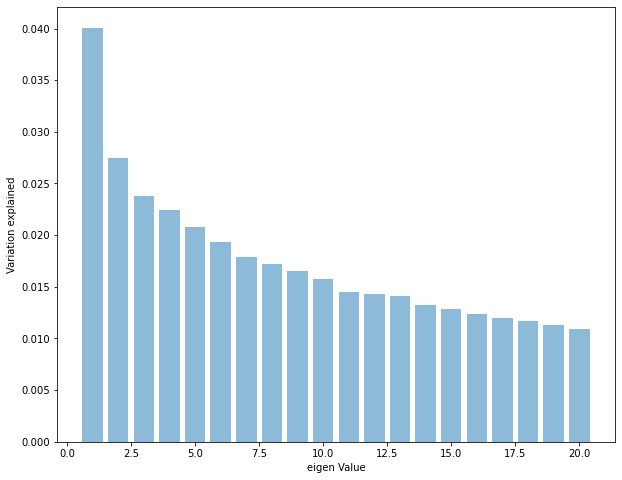

In [111]:
# Plot of Variation explained vs eigen values/principal components
plt.figure(figsize=(10,8))
plt.bar(list(range(1,21)),pca.explained_variance_ratio_,alpha=0.5, align='center')
plt.ylabel('Variation explained')
plt.xlabel('eigen Value')
plt.show()

[0.04008483 0.0675662  0.09134608 0.11378197 0.13454993 0.15384447
 0.17168599 0.1888684  0.20540624 0.22112565 0.23565861 0.24997449
 0.26403744 0.27725902 0.29014918 0.30252989 0.31455322 0.32625829
 0.33760437 0.34856645]


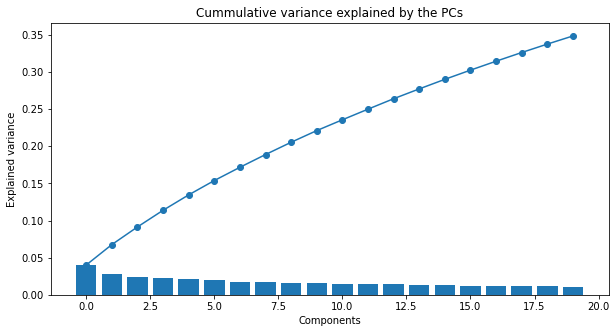

In [112]:
print(np.cumsum(pca.explained_variance_ratio_))
# Plot of cumulative varianc explained by principal components
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), '-o')
plt.bar(x = range(0, len(pca.components_)), height = pca.explained_variance_ratio_)
plt.title('Cummulative variance explained by the PCs')
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.show()

In [113]:
# Transform data based on principal components
Xpca = pca.transform(X_train_scaled)
Xpca

array([[ 0.38001408, -3.1940746 ,  1.63006628, ...,  1.12023366,
        -0.4495036 ,  0.80931742],
       [ 3.93362833,  1.02487972,  0.46503344, ...,  0.23356586,
         1.39519968,  0.24864995],
       [ 1.14802113, -1.89532691, -0.92189575, ..., -0.06537395,
        -1.36256729,  0.4420733 ],
       ...,
       [-2.19791719, -0.62125244,  0.43375792, ..., -0.46404636,
         0.90630578, -0.8097835 ],
       [-3.86170307,  4.1560185 ,  2.47899035, ..., -0.57630127,
         0.3149911 , -0.90921091],
       [-3.19810344, -2.23935493, -0.63164726, ..., -0.24155919,
         1.17665433, -0.62442632]])

In [114]:
#Function to calculate the model score on different PCA components on train and test set
def pca_scores(x_train_sc, x_test_sc,y_train,y_test, n_com, model):
    pca = PCA(n_components=n_com, random_state = 11 )
    pca.fit(x_train_sc)
    Xpca = pca.transform(x_train_sc)
    model.fit(Xpca, y_train)
    train_score = model.score(Xpca, y_train)
    Xpca_test = pca.transform(x_test_sc)
    test_score=model.score(Xpca_test, y_test)
    print(n_com, train_score, test_score)
    return train_score, test_score

In [115]:
#Code to pass different values for of principal component to the function
components = []
scores=[]
hue = []

for i in range(3,21):
    train_score, test_score = pca_scores(X_train_scaled, X_test_scaled,y_train,y_test, i, NNH)
    components.append(i)
    scores.append(train_score)
    hue.append("Train")
    components.append(i)
    scores.append(test_score)
    hue.append("Test")

3 0.80615234375 0.6913439635535308
4 0.8466796875 0.7403189066059226
5 0.86328125 0.7961275626423691
6 0.88623046875 0.826879271070615
7 0.8974609375 0.8610478359908884
8 0.91259765625 0.8656036446469249
9 0.927734375 0.8826879271070615
10 0.931640625 0.8838268792710706
11 0.93408203125 0.9111617312072893
12 0.9404296875 0.8940774487471527
13 0.9482421875 0.9031890660592256
14 0.94580078125 0.9100227790432802
15 0.94970703125 0.9100227790432802
16 0.95263671875 0.9168564920273349
17 0.9482421875 0.9191343963553531
18 0.95166015625 0.9214123006833713
19 0.95361328125 0.9271070615034168
20 0.955078125 0.9236902050113895


In [116]:
pca_summary = pd.DataFrame(data={"components": components, "Score": scores, 'Data':hue})
pca_summary.head()

,components,Score,Data
0,3,0.806152,Train
1,3,0.691344,Test
2,4,0.846680,Train
3,4,0.740319,Test
4,5,0.863281,Train


In [117]:
trMax = pca_summary[pca_summary['Data']=="Test"]['Score'].max()

In [118]:
teMax = pca_summary[pca_summary['Data']=="Train"]['Score'].max()

In [119]:
pca_summary[pca_summary['Score'] == trMax]

,components,Score,Data
33,19,0.927107,Test


In [120]:
# Storing corresponding train and test score for PCA-based (n=19) KNN from the output of for loop
knn_pca_train_score = 0.95361328125
knn_pca_test_score = 0.9271070615034168

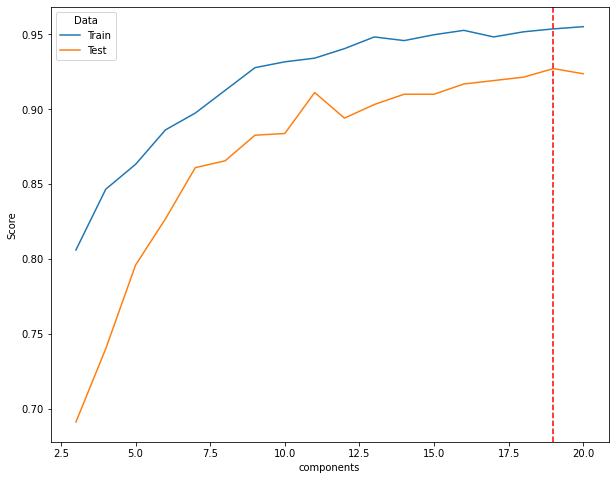

In [121]:
#Plot to display the principal component
plt.figure(figsize=(10, 8))
sns.lineplot(data=pca_summary, x='components' , y= 'Score', hue='Data')
plt.axvline(x=19, color='red', linestyle='--')
#plt.axhline(y=0.9, color='red', linestyle='--')
plt.show();

**<span style="color:blue">Observations</span>**
- We are able to improve the classification accuracy on test data from ~77% using cross validation techniques to ~93% using PCA transformed data with only 19 principal components.
- It looks like increasing the number principal components may further increase the train/test accuracy however that will result in increased number of dimensions for little increase in accuracy.
- Thus, to avoid the curse of dimensionality and in the interest of time we will stick to 19 principal of components for subsequent analyses.

### Display and explain the classification report in detail

In [122]:
#Execute the model (KNN Classifer) with the best fit PCA component 
pca = PCA(n_components=19, random_state = 11)
pca.fit(X_train_scaled)
Xpca_train_2 = pca.transform(X_train_scaled)
NNH.fit(Xpca_train_2, y_train)
knn_pca_train_score = NNH.score(Xpca_train_2, y_train)
Xpca_test_02 = pca.transform(X_test_scaled)
knn_pca_test_score = NNH.score(Xpca_test_02, y_test)

print("kNN PCA Train Score:", knn_pca_train_score)
print("kNN PCA Test Score:", knn_pca_test_score)

kNN PCA Train Score: 0.95361328125
kNN PCA Test Score: 0.9271070615034168


In [123]:
#Generate the classification report on the train set
y_predict_train = NNH.predict(Xpca_train_2)
print(classification_report(y_train, y_predict_train))

              precision    recall  f1-score   support

          -1       0.99      0.91      0.95      1014
           1       0.92      0.99      0.96      1034

    accuracy                           0.95      2048
   macro avg       0.96      0.95      0.95      2048
weighted avg       0.96      0.95      0.95      2048



In [124]:
#Generate the confusion matrix on the train set
print(confusion_matrix(y_train, y_predict_train))

[[ 925   89]
 [   6 1028]]


In [125]:
#Generate the classification report on the test set
y_predict_test = NNH.predict(Xpca_test_02)
print(confusion_matrix(y_test, y_predict_test))
print(classification_report(y_test, y_predict_test))

[[389  60]
 [  4 425]]
              precision    recall  f1-score   support

          -1       0.99      0.87      0.92       449
           1       0.88      0.99      0.93       429

    accuracy                           0.93       878
   macro avg       0.93      0.93      0.93       878
weighted avg       0.93      0.93      0.93       878



**<span style="color:blue">Observations</span>**
- The kNN model built using PCA transformed data achieved an overall accuracy of ~93% on test data set and ~95% on train data set. Thus, it is a well fitted model for classification.
- Model shows impressive recall of ~99% for "Fail" class i.e. it does excellent job of predicting Failed instances from actually Failed records
- Also the precision for the "Pass" class is ~99% i.e. it does impressive job of predicting Passed instances from total predicted positive records

### Apply the above steps for all possible models that you have learnt so far

- **Techniques to be applied on scaled data are**, 
    - Cross Validation, 
    - Hyper-parameter tuning 
    - Dimensionality reduction 


- **Different Supervised learning models to be used**,

    - Logistic Regression, 
    - Naive Bayes classifier, 
    - Support vector classifier
    - Decision tree
    - Random forest classifier


- *In the interest of time*, based on the PCA analysis done in Q. 5D, we will fix the number of principal components i.e. 19

### Logistic Regression

In [126]:
# Create a model using Logistic Regression and apply PCA and RandomizedSearchCV on the scaled data
cross_val = 10
pca = PCA()
lg = LogisticRegression()
pipeline_lg = Pipeline([("pca", pca),('logreg', lg)])
params_lg = {'pca__n_components': [19],
          'pca__random_state' : [11],
          'logreg__random_state': [42], 
          'logreg__max_iter': [1000], 
          'logreg__penalty' : ['l1', 'l2', 'elasticnet', 'None'],
          'logreg__C': [0.1, 1, 10, 100, 1000],
          'logreg__solver' : ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']         
         }
rs_lg = RandomizedSearchCV(pipeline_lg, params_lg, cv=cross_val, n_iter=200)
rs_lg.fit(X_train_scaled,y_train)
y_predict_lg = rs_lg.predict(X_test_scaled)
rs_lg_train_score = rs_lg.score(X_train_scaled, y_train)
rs_lg_test_score = rs_lg.score(X_test_scaled, y_test)
print("\n\nRandom Search Logistic Regression using RandomizedSearchCV\n\n")
print("Train Score:", rs_lg_train_score)
print("Test Score:", rs_lg_test_score)
print("\nConfusion matrix for test data\n")
print(metrics.confusion_matrix(y_test, y_predict_lg))
print("\nClassification report for test data\n")
print(metrics.classification_report(y_test, y_predict_lg))
print("\nBest parameters:\n")
rs_lg.best_params_



Random Search Logistic Regression using RandomizedSearchCV


Train Score: 0.72412109375
Test Score: 0.7255125284738041

Confusion matrix for test data

[[310 139]
 [102 327]]

Classification report for test data

              precision    recall  f1-score   support

          -1       0.75      0.69      0.72       449
           1       0.70      0.76      0.73       429

    accuracy                           0.73       878
   macro avg       0.73      0.73      0.73       878
weighted avg       0.73      0.73      0.73       878


Best parameters:



{'pca__random_state': 11,
 'pca__n_components': 19,
 'logreg__solver': 'saga',
 'logreg__random_state': 42,
 'logreg__penalty': 'l1',
 'logreg__max_iter': 1000,
 'logreg__C': 0.1}

### Naive Bayes classifier

In [127]:
#Create a model using Naive Bayes classifier and apply PCA and RandomizedSearchCV on the scaled data 
cross_val = 10
pca = PCA()
gnb = GaussianNB()
pipeline_gnb = Pipeline([("pca", pca),('gnb', gnb)])
params_nb = {'pca__n_components': [19],
          'pca__random_state': [11]        
         }
rs_gnb = RandomizedSearchCV(pipeline_gnb, params_nb, cv=cross_val, n_iter=200)
rs_gnb.fit(X_train_scaled,y_train)
y_predict_gnb = rs_gnb.predict(X_test_scaled)
rs_gnb_train_score = rs_gnb.score(X_train_scaled, y_train)
rs_gnb_test_score = rs_gnb.score(X_test_scaled, y_test)

print("\n\nGaussian Naive Bayes Classifier using RandomizedSearchCV\n\n")
print("Train Score:", rs_gnb_train_score)
print("Test Score:", rs_gnb_test_score)
print("\nConfusion matrix for test data\n")
print(metrics.confusion_matrix(y_test, y_predict_gnb))
print("\nClassification report for test data\n")
print(metrics.classification_report(y_test, y_predict_gnb))
print("\nBest parameters:\n")
rs_gnb.best_params_



Gaussian Naive Bayes Classifier using RandomizedSearchCV


Train Score: 0.724609375
Test Score: 0.7334851936218679

Confusion matrix for test data

[[401  48]
 [186 243]]

Classification report for test data

              precision    recall  f1-score   support

          -1       0.68      0.89      0.77       449
           1       0.84      0.57      0.68       429

    accuracy                           0.73       878
   macro avg       0.76      0.73      0.72       878
weighted avg       0.76      0.73      0.73       878


Best parameters:



{'pca__random_state': 11, 'pca__n_components': 19}

### Support Vector Machine

In [128]:
#Create a model using support vector classifier and apply PCA and GridSearchCV on the scaled data 
cross_val = 5
pca = PCA()
svc = SVC()
pipeline_svc = Pipeline([("pca", pca),('svc', svc)])
params_svc = {'pca__n_components': [19],
          'pca__random_state': [11],
          'svc__C':[0.1, 1, 10, 100],
          'svc__kernel': ['linear', 'rbf', 'sigmoid'],
          'svc__gamma': [1, 0.1, 0.01]
          }
gs_svc = GridSearchCV(pipeline_svc, params_svc, cv=cross_val)
gs_svc.fit(X_train_scaled,y_train)
y_predict_svc = gs_svc.predict(X_test_scaled)
gs_svc_train_score = gs_svc.score(X_train_scaled, y_train)
gs_svc_test_score = gs_svc.score(X_test_scaled, y_test)

print("\n\nSupport Vector Classifier using GridSearchCV\n\n")
print("Train Score:", gs_svc_train_score)
print("Test Score:", gs_svc_test_score)
print("\nConfusion matrix for test data\n")
print(metrics.confusion_matrix(y_test, y_predict_svc))
print("\nClassification report for test data\n")
print(metrics.classification_report(y_test, y_predict_svc))
print("\nBest parameters:\n")
gs_svc.best_params_



Support Vector Classifier using GridSearchCV


Train Score: 1.0
Test Score: 0.9669703872437357

Confusion matrix for test data

[[445   4]
 [ 25 404]]

Classification report for test data

              precision    recall  f1-score   support

          -1       0.95      0.99      0.97       449
           1       0.99      0.94      0.97       429

    accuracy                           0.97       878
   macro avg       0.97      0.97      0.97       878
weighted avg       0.97      0.97      0.97       878


Best parameters:



{'pca__n_components': 19,
 'pca__random_state': 11,
 'svc__C': 10,
 'svc__gamma': 0.1,
 'svc__kernel': 'rbf'}

### Decision Tree Classifier

In [129]:
#Create a model using decision tree classifier and apply PCA and GridSearchCV on the scaled data
cross_val = 5
pca = PCA()
dt = DecisionTreeClassifier()
pipeline_dt = Pipeline([("pca", pca),('decitree', dt)])
params_dt = {'pca__n_components': [19],
          'pca__random_state' : [11],
          'decitree__criterion': ['gini'],
          'decitree__max_depth' : list(range(3,20)),
          'decitree__max_features': ['sqrt','log2'],
          'decitree__random_state' :[1]
         }
                                  
gs_dt = GridSearchCV(pipeline_dt, params_dt, cv=cross_val)
gs_dt.fit(X_train_scaled,y_train)
y_predict_dt = gs_dt.predict(X_test_scaled)
                                  
gs_dt_train_score = gs_dt.score(X_train_scaled, y_train)
gs_dt_test_score = gs_dt.score(X_test_scaled, y_test)

print("\n\nDecision Tree Classifier using GridSearchCV\n\n")
print("Train Score:", gs_dt_train_score)
print("Test Score:", gs_dt_test_score)
print("\nConfusion matrix for test data\n")
print(metrics.confusion_matrix(y_test, y_predict_dt))
print("\nClassification report for test data\n")
print(metrics.classification_report(y_test, y_predict_dt))
print("\nBest parameters:\n")
gs_dt.best_params_



Decision Tree Classifier using GridSearchCV


Train Score: 0.9775390625
Test Score: 0.8234624145785877

Confusion matrix for test data

[[350  99]
 [ 56 373]]

Classification report for test data

              precision    recall  f1-score   support

          -1       0.86      0.78      0.82       449
           1       0.79      0.87      0.83       429

    accuracy                           0.82       878
   macro avg       0.83      0.82      0.82       878
weighted avg       0.83      0.82      0.82       878


Best parameters:



{'decitree__criterion': 'gini',
 'decitree__max_depth': 17,
 'decitree__max_features': 'sqrt',
 'decitree__random_state': 1,
 'pca__n_components': 19,
 'pca__random_state': 11}

### Random Forest Classifier

In [130]:
#Create a model using Random Forest classifier and apply PCA and GridSearchCV on the scaled data
cross_val = 5
pca = PCA()
rfc = RandomForestClassifier()
pipeline_rfc = Pipeline([("pca", pca),('randomfc', rfc)])
params_rfc = {'pca__n_components': [19],
          'pca__random_state' : [11],
          'randomfc__n_estimators':[100],
          'randomfc__criterion': ['gini'],
          'randomfc__max_depth' : list(range(3,20)),
          'randomfc__max_features': ['sqrt','log2'],
          'randomfc__random_state' :[1],
          'randomfc__class_weight': ['balanced','balanced_subsample','None']
         }
                                  
gs_rfc = GridSearchCV(pipeline_rfc, params_rfc, cv=cross_val)
gs_rfc.fit(X_train_scaled,y_train)
y_predict_rfc = gs_rfc.predict(X_test_scaled)

gs_rfc_train_score = gs_rfc.score(X_train_scaled, y_train)
gs_rfc_test_score = gs_rfc.score(X_test_scaled, y_test)

print("\n\nRandom Forest Classifier using GridSearchCV\n\n")
print("Train Score:", gs_rfc_train_score)
print("Test Score:", gs_rfc_test_score)
print("\nConfusion matrix for test data\n")
print(metrics.confusion_matrix(y_test, y_predict_rfc))
print("\nClassification report for test data\n")
print(metrics.classification_report(y_test, y_predict_rfc))
print("\nBest parameters:\n")
gs_rfc.best_params_



Random Forest Classifier using GridSearchCV


Train Score: 0.99951171875
Test Score: 0.9236902050113895

Confusion matrix for test data

[[412  37]
 [ 30 399]]

Classification report for test data

              precision    recall  f1-score   support

          -1       0.93      0.92      0.92       449
           1       0.92      0.93      0.92       429

    accuracy                           0.92       878
   macro avg       0.92      0.92      0.92       878
weighted avg       0.92      0.92      0.92       878


Best parameters:



{'pca__n_components': 19,
 'pca__random_state': 11,
 'randomfc__class_weight': 'balanced',
 'randomfc__criterion': 'gini',
 'randomfc__max_depth': 17,
 'randomfc__max_features': 'sqrt',
 'randomfc__n_estimators': 100,
 'randomfc__random_state': 1}

## Post Training and Conclusion

### Display and compare all the models designed with their train and test accuracies

In [131]:
models_summary = pd.DataFrame({
    "Model" : ['K-Nearest Neighbor', 'K-Nearest Neighbor', 'K-Nearest Neighbor', 'K-Nearest Neighbor',
              'Logistic Regression', 'Gaussian Naive Bayes Classifier', 'Support Vector Classifier', 
              'Decision Tree Classifier', 'Random Forest Classifier'],
    
    "Hyperparameter technique" : ['None', 'GridSearchCV', 'RandomizedSearchCV', 'None', 'RandomizedSearchCV', 
                                  'RandomizedSearchCV', 'GridSearchCV', 'GridSearchCV', 'GridSearchCV'],
    
    "Dimensionality reduction" : ['None', 'None', 'None', 'PCA', 'PCA', 'PCA', 'PCA', 'PCA', 'PCA'],
    
    "Method" : ["KNN_None_None", "KNN_GS_None", "KNN_RS_None", "KNN_None_PCA", "LGR_RS_PCA", "GNB_RS_PCA",
               "SVC_GS_PCA", "DT_GS_PCA", "RF_GS_PCA"],
    
    "Train score" : [knn_base_model_train_score, gs_knn_train_score, rs_knn_train_score, knn_pca_train_score,
                    rs_lg_train_score, rs_gnb_train_score, gs_svc_train_score, gs_dt_train_score, gs_rfc_train_score],
    
    "Test score" : [knn_base_model_test_score, gs_knn_test_score, rs_knn_test_score, knn_pca_test_score,
                   rs_lg_test_score, rs_gnb_test_score, gs_svc_test_score, gs_dt_test_score, gs_rfc_test_score]
}).sort_values(by="Test score", ascending=False).reset_index(drop=True)

In [132]:
models_summary

,Model,Hyperparameter technique,Dimensionality reduction,Method,Train score,Test score
0,Support Vector Classifier,GridSearchCV,PCA,SVC_GS_PCA,1.000000,0.966970
1,K-Nearest Neighbor,None,PCA,KNN_None_PCA,0.953613,0.927107
2,Random Forest Classifier,GridSearchCV,PCA,RF_GS_PCA,0.999512,0.923690
3,Decision Tree Classifier,GridSearchCV,PCA,DT_GS_PCA,0.977539,0.823462
4,K-Nearest Neighbor,GridSearchCV,None,KNN_GS_None,0.892090,0.765376
5,K-Nearest Neighbor,RandomizedSearchCV,None,KNN_RS_None,1.000000,0.765376
6,Gaussian Naive Bayes Classifier,RandomizedSearchCV,PCA,GNB_RS_PCA,0.724609,0.733485
7,Logistic Regression,RandomizedSearchCV,PCA,LGR_RS_PCA,0.724121,0.725513
8,K-Nearest Neighbor,None,None,KNN_None_None,0.645996,0.555809


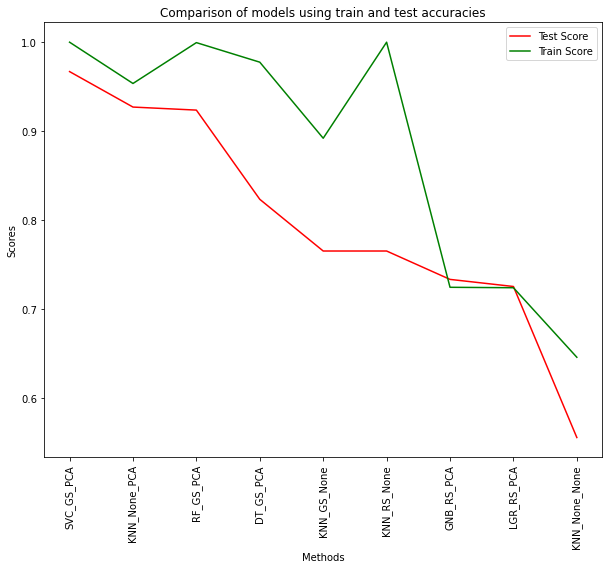

In [133]:
# Visulization of comparative performance of models using line plots
plt.figure(figsize=(10,8))
sns.lineplot(data=models_summary, x = 'Method', y = 'Test score', color = 'red')
sns.lineplot(data=models_summary, x = 'Method', y = 'Train score', color = 'green')
plt.xlabel('Methods') 
plt.ylabel('Scores')
plt.title("Comparison of models using train and test accuracies")
plt.xticks(rotation=90)
plt.legend(labels=["Test Score","Train Score"])
plt.show();

**Note**
- Methods on X-axis are labeled as follows,
\<Classifier>_\<Hyperparameter_technique>_\<Dimensionality_reduction>

### Selection of the best trained model along with detailed comments

- From the above table, it can be seen that Support Vector Classifier (SVC) based model obtained using PCA transformed data  shows best test accuracy of ~97% as determined using GridSearchCV technique. 

- Compared to base kNN model, SVC has improved test accuracy by ~40% (from ~57% to ~97%). This is significant improvement in the performance of model in classification of test data set. 

- The next best models are K-Nearest Neighbor and Random Forest Classifiers with Test accuracy of ~93%, but stll have ~4% less accuracy compared to SVC-based model.

A summary of performance metrics for SVC-based classifiers are shown below,

In [134]:
print("\n\nSupport Vector Classifier using GridSearchCV\n\n")
print("Train Score:", gs_svc_train_score)
print("Test Score:", gs_svc_test_score)
print("\nConfusion matrix for test data\n")
print(metrics.confusion_matrix(y_test, y_predict_svc))
print("\nClassification report for test data\n")
print(metrics.classification_report(y_test, y_predict_svc))
print("\nBest parameters:\n")
gs_svc.best_params_



Support Vector Classifier using GridSearchCV


Train Score: 1.0
Test Score: 0.9669703872437357

Confusion matrix for test data

[[445   4]
 [ 25 404]]

Classification report for test data

              precision    recall  f1-score   support

          -1       0.95      0.99      0.97       449
           1       0.99      0.94      0.97       429

    accuracy                           0.97       878
   macro avg       0.97      0.97      0.97       878
weighted avg       0.97      0.97      0.97       878


Best parameters:



{'pca__n_components': 19,
 'pca__random_state': 11,
 'svc__C': 10,
 'svc__gamma': 0.1,
 'svc__kernel': 'rbf'}

### Pickle the selected model for future use

In [135]:
modelName = "SVC_model.pkl"
with open(modelName, "wb") as f:
    pickle.dump(gs_svc, f)
        
print("\nBest Model generated using SVC is saved as", modelName)


Best Model generated using SVC is saved as SVC_model.pkl


### Conclusion on the results

In [136]:
svs_mean_scores = pd.Series(gs_svc.cv_results_['mean_test_score'])
#svs_mean_scores = pd.Series(gs_rfc.cv_results_['mean_test_score']).dropna()

meanAcc = round(svs_mean_scores.mean()*100, 2)
std = round(svs_mean_scores.std()*100, 2)
maxAcc = round(svs_mean_scores.max()*100, 2)

print("\nMean CV accuracy: ",  meanAcc, "%\nStd: ",  std, sep="")
print("Max observed accuracy: ", maxAcc, "%", sep="")
print("Range of accuracy with ~2 standard deviation:", meanAcc - 1.96*std, "to", round(meanAcc + 1.96*std, 2))


Mean CV accuracy: 68.35%
Std: 16.65
Max observed accuracy: 96.24%
Range of accuracy with ~2 standard deviation: 35.716 to 100.98


**<span style="color:blue">Conclusions</span>**
- Applying PCA, cross validation, hyperparameter tuning technique on the scaled data greatly helped improve the performance of the support vector classifier model.
- We started the analysis on the original data with 591 features and the model could give us the best result with just 19 PCA transformed features. This lead to significant dimensionality reduction by 30 folds thus saving the time of the analysis.
- Model shows impressive recall of ~99% for "Pass" class i.e. it does excellent job of predicting Pass instances from actually Passed records from the test dataset.
- Also the precision for the "Fail" class is ~99% i.e. it does an impressive job of predicting Failed instances from total predicted positive records on the test dataset.
- Given any dataset on production environment the model is expected to show an accuracy of 35% to 100% at 95% confidence level